# Image Classification with Convolutional Neural Networks

## Task 1: Implementation and Comparison of CNN Architectures
##### Aye Khin Khin Hpone (Yolanda Lim)_125970
---

### **Dataset: CIFAR-10**
- **Classes:** 10 object categories (airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck)
- **Images:** 60,000 total (50,000 training + 10,000 test), 32×32 RGB resolution
- **Split:** 45,000 training / 5,000 validation / 10,000 test

---

### **Architectures Implemented:**
1. **AlexNet-style CNN (Baseline)** - Custom 5-layer convolutional neural network with batch normalization and dropout regularization (12.75M parameters)
2. **VGG11 (Modern Deep Network)** - 11-layer deep network with uniform 3×3 convolutions and transfer learning from ImageNet pretrained weights (128.81M parameters)

---

### **Experimental Design:**
- **Optimizers:** Stochastic Gradient Descent (SGD) vs Adaptive Moment Estimation (Adam) with controlled ablation study
- **Learning Rate Schedules:** StepLR (fixed schedule) and ReduceLROnPlateau (adaptive schedule)
- **Training Duration:** 30 epochs (AlexNet), 25 epochs (VGG11)

---

### **Visualizations and Evaluation Metrics:**
- Training and validation accuracy curves over epochs
- Training and validation loss curves over epochs
- Learning rate schedule progression
- Confusion matrices (normalized and unnormalized)
- Examples of misclassified images
- Activation maps from layer 1 and layer 2 of each model
- Comparative architecture performance analysis
- Convergence speed analysis

---

### **Notebook Organization:**
1. **Setup and Configuration** - Library imports, path configuration, GPU initialization
2. **Data Loading and Preprocessing** - CIFAR-10 dataset with data augmentation and split strategy
3. **Model Architecture Definitions** - AlexNet-style CNN and VGG11 implementation details
4. **Training and Evaluation Utilities** - Training loop, evaluation functions, visualization methods
5. **Experimental Runs** - Three independent training experiments with varying configurations
6. **Comparative Analysis** - Quantitative and qualitative performance comparison
7. **Activation Map Visualization** - Feature learning analysis from convolutional layers
8. **Discussion and Conclusions** - Performance analysis, convergence behavior, and limitations

---


---

## Section 1: Setup and Configuration


In [1]:
"""This notebook implements and compares CNN architectures on CIFAR-10:
- AlexNet-style CNN (baseline, 5 layers, 12.75M parameters)
- VGG11 (modern deep network with transfer learning, 11 layers, 128.81M parameters)
"""

# ============================================================================
# IMPORTS
# ============================================================================

# Standard library
import os
import sys
import json
import random
import platform
from pathlib import Path

# Scientific computing
import numpy as np

# Visualization
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import itertools

# Deep learning
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, Subset
import torchvision
from torchvision import transforms, datasets, models

# Metrics
from sklearn.metrics import confusion_matrix, classification_report

# ============================================================================
# CONFIGURATION
# ============================================================================

# Paths
SEED = 42
DATA_DIR = "./data"
OUT_DIR = "./outputs"

# Create output directory
os.makedirs(OUT_DIR, exist_ok=True)

# Warnings
print("✓ Imports and configuration loaded successfully")

✓ Imports and configuration loaded successfully


In [2]:
"""
GPU Setup and Reproducibility Configuration
"""

# ============================================================================
# DEVICE SETUP FUNCTION
# ============================================================================

def setup_device_and_seeds(gpu_id=2, seed=42):
    """
    Configure GPU device and set random seeds for reproducibility.
    
    Args:
        gpu_id (int): GPU index to use (default: 2)
        seed (int): Random seed for reproducibility (default: 42)
    
    Returns:
        torch.device: Configured device (cuda or cpu)
    """
    # Device selection
    device = torch.device(f"cuda:{gpu_id}" if torch.cuda.is_available() else "cpu")
    print(f"\n{'='*70}")
    print(f"DEVICE CONFIGURATION")
    print(f"{'='*70}")
    print(f"Device: {device}")
    
    # GPU information
    if device.type == 'cuda':
        print(f"GPU Name: {torch.cuda.get_device_name(gpu_id)}")
        print(f"CUDA Version: {torch.version.cuda}")
        print(f"Total VRAM: {torch.cuda.get_device_properties(gpu_id).total_memory / 1024**3:.2f} GB")
        
        # Reproducibility settings
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        
        # Performance optimizations
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True
        torch.cuda.empty_cache()
        
        print("✓ GPU optimizations enabled (TF32, deterministic mode)")
    else:
        print("⚠ Running on CPU (training will be slower)")
    
    # Random seed configuration
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    if device.type == 'cuda':
        torch.cuda.manual_seed_all(seed)
    
    print(f"✓ Random seeds set (seed={seed})")
    print(f"{'='*70}\n")
    
    return device

# ============================================================================
# INITIALIZE DEVICE
# ============================================================================

DEVICE = setup_device_and_seeds(gpu_id=2, seed=SEED)
os.environ['TQDM_DISABLE'] = '1'  # Reduce disk I/O on server


DEVICE CONFIGURATION
Device: cuda:2
GPU Name: NVIDIA GeForce RTX 2080 Ti
CUDA Version: 12.8
Total VRAM: 10.75 GB
✓ GPU optimizations enabled (TF32, deterministic mode)
✓ Random seeds set (seed=42)



---

## Section 2: Data Loading and Preprocessing

### CIFAR-10 Dataset Preparation
This section implements the data loading pipeline for CIFAR-10, including appropriate data augmentation strategies for the training set and proper train/validation/test splits.

**Data Augmentation Strategy:**
- **Training Set:** Random cropping with padding, random horizontal flipping, color jitter (brightness, contrast, saturation), and normalization
- **Validation and Test Sets:** Normalization only (no augmentation applied to prevent data leakage and ensure unbiased evaluation)


In [3]:
"""
CIFAR-10 Dataset Loading and Preprocessing
"""

# ============================================================================
# DATA TRANSFORMS
# ============================================================================

# Training augmentation: RandomCrop, ColorJitter, RandomHorizontalFlip
train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
])

# Test/Val transform: No augmentation
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
])

# ============================================================================
# LOAD DATASETS
# ============================================================================

# Download CIFAR-10 dataset
full_train_dataset = datasets.CIFAR10(root=DATA_DIR, train=True, download=True, transform=None)
test_dataset = datasets.CIFAR10(root=DATA_DIR, train=False, download=True, transform=test_transform)

# Split training into train (45k) and validation (5k)
train_size = 45000
val_size = 5000
train_indices = list(range(train_size))
val_indices = list(range(train_size, train_size + val_size))

# Create train and val subsets with appropriate transforms
train_dataset = datasets.CIFAR10(root=DATA_DIR, train=True, download=False, transform=train_transform)
val_dataset = datasets.CIFAR10(root=DATA_DIR, train=True, download=False, transform=test_transform)

train_subset = Subset(train_dataset, train_indices)
val_subset = Subset(val_dataset, val_indices)

# ============================================================================
# CREATE DATA LOADERS
# ============================================================================

BATCH_SIZE = 64
NUM_WORKERS = 0 if os.name == 'nt' else 2  # Windows multiprocessing fix

train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True, 
                         num_workers=NUM_WORKERS, pin_memory=True if torch.cuda.is_available() else False)

val_loader = DataLoader(val_subset, batch_size=BATCH_SIZE, shuffle=False, 
                       num_workers=NUM_WORKERS, pin_memory=True if torch.cuda.is_available() else False)

test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, 
                        num_workers=NUM_WORKERS, pin_memory=True if torch.cuda.is_available() else False)

# CIFAR-10 class names
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# ============================================================================
# DATASET SUMMARY
# ============================================================================

print(f"\n{'='*70}")
print("CIFAR-10 DATASET INFORMATION")
print(f"{'='*70}")
print(f"Training samples:   {len(train_subset):>10,}")
print(f"Validation samples: {len(val_subset):>10,}")
print(f"Test samples:       {len(test_dataset):>10,}")
print(f"Batch size:         {BATCH_SIZE:>10}")
print(f"Number of classes:  {len(classes):>10}")
print(f"Image shape:        {test_dataset[0][0].shape}")
print(f"Classes: {', '.join(classes)}")
print(f"{'='*70}\n")

print("✓ Data loaders created successfully")


CIFAR-10 DATASET INFORMATION
Training samples:       45,000
Validation samples:      5,000
Test samples:           10,000
Batch size:                 64
Number of classes:          10
Image shape:        torch.Size([3, 32, 32])
Classes: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck

✓ Data loaders created successfully


---

### Data Verification and Visualization

This subsection verifies the data loading pipeline by checking batch shapes and visualizing representative samples from each class to ensure correct preprocessing.

In [4]:
"""
Verify data loader shapes and sample batch
"""

# Get a sample batch to verify shapes
sample_images, sample_labels = next(iter(train_loader))
print(f"\n{'='*70}")
print("BATCH SHAPE VERIFICATION")
print(f"{'='*70}")
print(f"Sample batch images shape: {sample_images.shape}")
print(f"Sample batch labels shape: {sample_labels.shape}")
print(f"Single image shape: {sample_images[0].shape}")
print(f"Data type: {sample_images.dtype}")
print(f"Value range: [{sample_images.min():.3f}, {sample_images.max():.3f}]")
print(f"{'='*70}\n")

print("✓ Data shapes verified successfully")


BATCH SHAPE VERIFICATION
Sample batch images shape: torch.Size([64, 3, 32, 32])
Sample batch labels shape: torch.Size([64])
Single image shape: torch.Size([3, 32, 32])
Data type: torch.float32
Value range: [-1.989, 2.126]

✓ Data shapes verified successfully


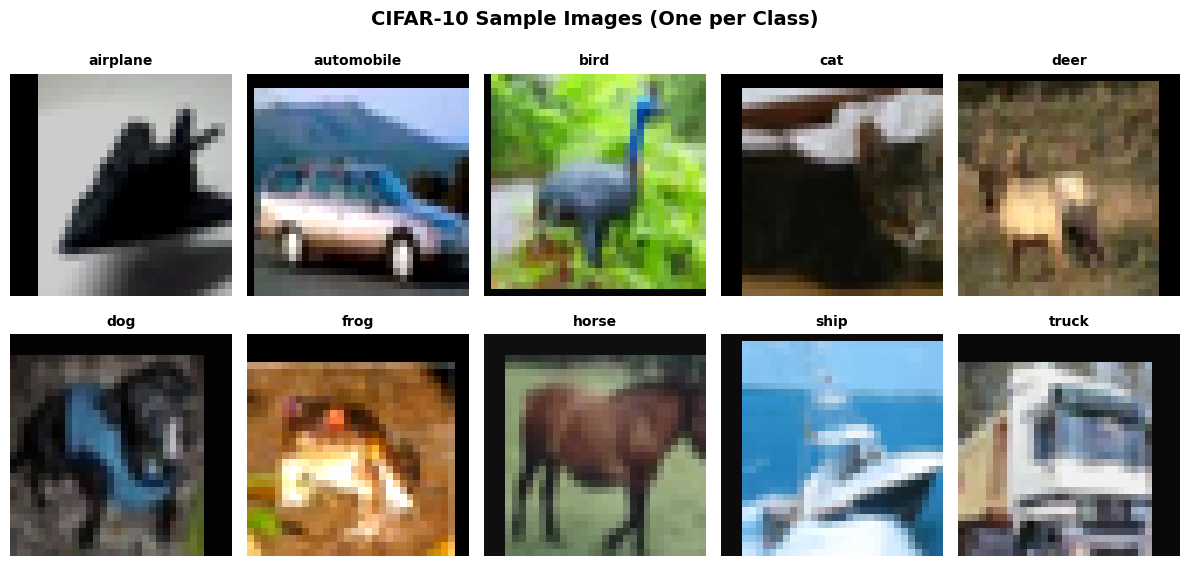

✓ Sample images visualized and saved


In [5]:
"""
Visualize sample images from CIFAR-10 dataset (one per class)
"""

# Collect one image per class
images_per_class = {}
for img, label in train_subset:
    if label not in images_per_class:
        images_per_class[label] = img
    if len(images_per_class) == 10:
        break

# Plot sample images
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
fig.suptitle("CIFAR-10 Sample Images (One per Class)", fontsize=14, fontweight='bold')

# Denormalize for visualization
mean = np.array([0.4914, 0.4822, 0.4465])
std = np.array([0.2470, 0.2435, 0.2616])

for i, (label, img_tensor) in enumerate(sorted(images_per_class.items())):
    ax = axes[i // 5, i % 5]
    
    # Convert tensor to numpy and denormalize
    img = img_tensor.numpy().transpose(1, 2, 0)
    img = img * std + mean
    img = np.clip(img, 0, 1)
    
    ax.imshow(img)
    ax.set_title(f'{classes[label]}', fontsize=10, fontweight='bold')
    ax.axis('off')

plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "cifar10_sample_images.png"), dpi=150, bbox_inches='tight')
plt.show()

print("✓ Sample images visualized and saved")

---

## Section 3: Model Architecture Definitions

### Architecture 1: AlexNet-style CNN (Baseline Model)
An AlexNet-inspired convolutional neural network adapted for CIFAR-10, serving as a baseline for performance comparison. This architecture demonstrates deeper CNN principles with five convolutional layers.

**Architecture Specifications:**
- Five convolutional layers with progressive channel expansion (64, 192, 384, 256, 256 channels)
- Batch normalization applied after each convolutional layer for training stability
- MaxPooling layers (2×2 kernel) for spatial downsampling after layers 1, 2, and 5
- Dropout regularization (probability = 0.5) in classifier layers to reduce overfitting
- Fully connected layers: 4096 → 2048 → 1024 → 10 (output classes)
- **Total Parameters:** Approximately 12.75 million trainable parameters


In [6]:
"""
AlexNetCNN: Baseline CNN Architecture (AlexNet-inspired)
- 5 convolutional layers with batch normalization
- Progressive channel expansion: 64 → 192 → 384 → 256 → 256
- Dropout regularization in classifier
"""

# ============================================================================
# MODEL DEFINITION
# ============================================================================

class AlexNetCNN(nn.Module):
    """
    AlexNet-inspired CNN for CIFAR-10 classification.
    
    Architecture (adapted for 32×32 images):
        - Conv1: 3→64 channels (3x3 kernel)
        - Conv2: 64→192 channels (3x3 kernel)  
        - Conv3: 192→384 channels (3x3 kernel)
        - Conv4: 384→256 channels (3x3 kernel)
        - Conv5: 256→256 channels (3x3 kernel)
        - FC1: 4096→2048
        - FC2: 2048→1024
        - FC3: 1024→10 (num_classes)
    """
    
    def __init__(self, num_classes=10):
        super(AlexNetCNN, self).__init__()
        
        # Feature extraction layers
        self.features = nn.Sequential(
            # Layer 1: 32x32 -> 16x16
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Layer 2: 16x16 -> 8x8
            nn.Conv2d(64, 192, kernel_size=3, padding=1),
            nn.BatchNorm2d(192),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Layer 3: 8x8 (no pooling)
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU(inplace=True),
            
            # Layer 4: 8x8 (no pooling)
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            
            # Layer 5: 8x8 -> 4x4
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        
        # Classifier layers
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256 * 4 * 4, 2048),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(2048, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, num_classes),
        )
    
    def forward(self, x):
        """Forward pass through the network."""
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

# ============================================================================
# MODEL INSTANTIATION
# ============================================================================

model = AlexNetCNN(num_classes=10).to(DEVICE)
print("✓ AlexNetCNN model created successfully")
print(f"\nModel architecture:\n{model}")

✓ AlexNetCNN model created successfully

Model architecture:
AlexNetCNN(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_run

---

### Architecture 2: VGG11 (Modern Deep Network)
A VGG-11 architecture implementing a uniform design with repeated 3×3 convolutions. This model leverages transfer learning from ImageNet pretrained weights.

**Architecture Specifications:**
- 11 layers organized in 5 convolutional blocks with repeated 3×3 convolutions
- Pretrained on ImageNet dataset (1.2 million images, 1000 classes)
- Final fully connected layer modified for CIFAR-10 classification (10 output classes)
- **Total Parameters:** Approximately 128.81 million trainable parameters
- **Key Advantage:** Uniform architecture with small receptive fields enables learning of complex features


In [7]:
"""
VGG11: Modern Architecture with Transfer Learning
- Pre-trained on ImageNet
- Modified for CIFAR-10 (10 classes)
"""

# ============================================================================
# VGG11 BUILDER FUNCTION
# ============================================================================

def get_vgg11(num_classes=10, pretrained=True, freeze_backbone=False):
    """
    Build VGG11 model with optional transfer learning.
    
    Args:
        num_classes (int): Number of output classes
        pretrained (bool): Load ImageNet pre-trained weights
        freeze_backbone (bool): Freeze all layers except final FC
    
    Returns:
        torch.nn.Module: Configured VGG11 model
    """
    # Load model with pre-trained weights
    if pretrained:
        weights = models.VGG11_Weights.DEFAULT
    else:
        weights = None
    
    model = models.vgg11(weights=weights)
    
    # Modify classifier for CIFAR-10
    # VGG's classifier is a Sequential module
    # Replace the last layer (index 6)
    num_features = model.classifier[6].in_features
    model.classifier[6] = nn.Linear(num_features, num_classes)
    
    # Optional: Freeze backbone for fine-tuning
    if freeze_backbone:
        for param in model.features.parameters():
            param.requires_grad = False
    
    return model

# ============================================================================
# MODEL INSTANTIATION
# ============================================================================

vgg_example = get_vgg11(pretrained=False).to(DEVICE)
print("✓ VGG11 model created successfully")
print(f"\nModel architecture:\n{vgg_example}")

✓ VGG11 model created successfully

Model architecture:
VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_siz

---

### Model Complexity Analysis
Quantitative comparison of model complexity through parameter counting. This analysis establishes the computational and memory requirements of each architecture.

**Expected Outcome:** VGG11 should demonstrate approximately 3.6 times more parameters than AlexNet-style CNN, reflecting its deeper architecture with uniform 3×3 convolutions and increased representational capacity.


In [8]:
"""
Analyze and compare model complexity
"""

# ============================================================================
# PARAMETER COUNTING FUNCTION
# ============================================================================

def count_parameters(model):
    """
    Count total and trainable parameters in a model.
    
    Args:
        model: PyTorch model
    
    Returns:
        tuple: (total_params, trainable_params)
    """
    total = sum(p.numel() for p in model.parameters())
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total, trainable

# ============================================================================
# COMPARE MODELS
# ============================================================================

alexnet_total, alexnet_trainable = count_parameters(model)
vgg_total, vgg_trainable = count_parameters(vgg_example)

print(f"\n{'='*70}")
print("MODEL COMPLEXITY COMPARISON")
print(f"{'='*70}")
print(f"{'Model':<20} {'Total Params':>20} {'Trainable Params':>20}")
print(f"{'-'*70}")
print(f"{'AlexNet-style CNN':<20} {alexnet_total:>20,} {alexnet_trainable:>20,}")
print(f"{'VGG11':<20} {vgg_total:>20,} {vgg_trainable:>20,}")
print(f"{'-'*70}")
print(f"{'Ratio (VGG11/AlexNet)':<20} {vgg_total/alexnet_total:>20.2f}x {vgg_trainable/alexnet_trainable:>20.2f}x")
print(f"{'='*70}")
print(f"\n Summary:")
print(f"   AlexNet-style CNN: {alexnet_total/1e6:.2f}M parameters")
print(f"   VGG11:  {vgg_total/1e6:.2f}M parameters")
print(f"   VGG11 is {vgg_total/alexnet_total:.1f}x larger than AlexNet\n")


MODEL COMPLEXITY COMPARISON
Model                        Total Params     Trainable Params
----------------------------------------------------------------------
AlexNet-style CNN              12,752,970           12,752,970
VGG11                         128,807,306          128,807,306
----------------------------------------------------------------------
Ratio (VGG11/AlexNet)                10.10x                10.10x

 Summary:
   AlexNet-style CNN: 12.75M parameters
   VGG11:  128.81M parameters
   VGG11 is 10.1x larger than AlexNet



---

## Section 4: Training and Evaluation Utilities

### Training Pipeline Implementation
This section implements the complete training and evaluation pipeline, including utility functions for model training, performance evaluation, and result visualization.

**Function Implementations:**
- `train_one_epoch()` - Executes single training epoch with mini-batch gradient descent and progress tracking
- `evaluate()` - Performs model evaluation on validation or test set with optional prediction extraction
- `fit()` - Implements complete training loop with learning rate scheduling and best model checkpointing
- `plot_history()` - Generates three-panel visualization (loss curves, accuracy curves, learning rate progression)
- `plot_confmat()` - Creates confusion matrix visualizations in both normalized and unnormalized formats
- `show_misclassified_images()` - Displays grid of incorrectly classified examples for error analysis


In [9]:
# Training + evaluation utilities
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import torch.optim as optim

def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    pbar = tqdm(loader, leave=False)
    for imgs, targets in pbar:
        imgs = imgs.to(device)
        targets = targets.to(device)
        outputs = model(imgs)
        loss = criterion(outputs, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * imgs.size(0)
        _, preds = outputs.max(1)
        correct += preds.eq(targets).sum().item()
        total += imgs.size(0)
        pbar.set_description(f"loss: {running_loss/total:.4f}, acc: {100*correct/total:.2f}%")
    return running_loss/total, correct/total

def evaluate(model, loader, criterion, device, return_preds=False):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_targets = []
    with torch.no_grad():
        for imgs, targets in loader:
            imgs = imgs.to(device)
            targets = targets.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, targets)
            running_loss += loss.item() * imgs.size(0)
            _, preds = outputs.max(1)
            correct += preds.eq(targets).sum().item()
            total += imgs.size(0)
            all_preds.append(preds.cpu().numpy())
            all_targets.append(targets.cpu().numpy())
    if return_preds:
        return running_loss/total, correct/total, np.concatenate(all_preds), np.concatenate(all_targets)
    return running_loss/total, correct/total

def fit(model, train_loader, val_loader, optimizer, scheduler, criterion, device, epochs, model_name="model"):
    history = {"train_loss":[], "train_acc":[], "val_loss":[], "val_acc":[], "lr":[]}
    best_val = 0.0
    best_path = os.path.join(OUT_DIR, f"{model_name}_best.pth")
    for epoch in range(1, epochs+1):
        # Track current learning rate
        current_lr = optimizer.param_groups[0]['lr']
        history["lr"].append(current_lr)
        
        train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, device)
        val_loss, val_acc = evaluate(model, val_loader, criterion, device)
        if scheduler is not None:
            # handle ReduceLROnPlateau vs StepLR
            try:
                scheduler.step(val_loss)
            except TypeError:
                scheduler.step()
        history["train_loss"].append(train_loss); history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss); history["val_acc"].append(val_acc)
        print(f"[{model_name}] Epoch {epoch}/{epochs} | LR {current_lr:.2e} | train_loss {train_loss:.4f} acc {train_acc*100:.2f}% | val_loss {val_loss:.4f} acc {val_acc*100:.2f}%")
        if val_acc > best_val:
            best_val = val_acc
            torch.save(model.state_dict(), best_path)
            print("Saved best:", best_path)
    return history, best_path

# plotting helpers
def plot_history(history, title_prefix):
    fig = plt.figure(figsize=(15,4))
    
    # Loss plot
    plt.subplot(1,3,1)
    plt.plot(history["train_loss"], label="train")
    plt.plot(history["val_loss"], label="val")
    plt.title(title_prefix + " Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Accuracy plot
    plt.subplot(1,3,2)
    plt.plot(history["train_acc"], label="train")
    plt.plot(history["val_acc"], label="val")
    plt.title(title_prefix + " Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Learning rate plot
    plt.subplot(1,3,3)
    plt.plot(history["lr"], color='green', linewidth=2)
    plt.title(title_prefix + " Learning Rate")
    plt.xlabel("Epoch")
    plt.ylabel("Learning Rate")
    plt.yscale('log')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(os.path.join(OUT_DIR, f"{title_prefix.replace(' ','_')}_history.png"))
    plt.show()

def plot_confmat(y_true, y_pred, classes, normalize=False, title="Confusion matrix"):
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype(float) / cm.sum(axis=1)[:, None]
    plt.figure(figsize=(8,8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    ticks = np.arange(len(classes))
    plt.xticks(ticks, classes, rotation=90)
    plt.yticks(ticks, classes)
    fmt = ".2f" if normalize else "d"
    thresh = cm.max()/2.
    for i,j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j,i, format(cm[i,j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i,j] > thresh else "black")
    plt.ylabel("True")
    plt.xlabel("Pred")
    plt.tight_layout()
    plt.savefig(os.path.join(OUT_DIR, f"{title.replace(' ','_')}.png"))
    plt.show()

def show_misclassified_images(model, loader, device, classes, max_images=12):
    model.eval()
    mis_imgs, mis_pred, mis_true = [], [], []
    mean = np.array([0.4914,0.4822,0.4465]).reshape(3,1,1)
    std = np.array([0.2470,0.2435,0.2616]).reshape(3,1,1)
    with torch.no_grad():
        for imgs, targets in loader:
            imgs = imgs.to(device)
            outputs = model(imgs)
            _, preds = outputs.max(1)
            for i in range(imgs.size(0)):
                if preds[i].item() != targets[i].item():
                    img = imgs[i].cpu().numpy()
                    img = img * std + mean
                    img = np.transpose(img, (1,2,0))
                    mis_imgs.append(img); mis_pred.append(classes[preds[i].item()]); mis_true.append(classes[targets[i].item()])
                if len(mis_imgs) >= max_images:
                    break
            if len(mis_imgs) >= max_images:
                break
    if len(mis_imgs)==0:
        print("No misclassified images found.")
        return
    cols = 4
    rows = (len(mis_imgs)+cols-1)//cols
    plt.figure(figsize=(cols*3, rows*3))
    for i in range(len(mis_imgs)):
        plt.subplot(rows,cols,i+1)
        plt.imshow(mis_imgs[i])
        plt.title(f"P:{mis_pred[i]}\nT:{mis_true[i]}")
        plt.axis("off")
    plt.tight_layout()
    plt.savefig(os.path.join(OUT_DIR, "misclassified.png"))
    plt.show()

---

### Unified Experiment Execution Function
A comprehensive wrapper function that orchestrates complete training experiments with configurable hyperparameters and automatic visualization generation.

**Capabilities:**
- Support for multiple optimizers: Stochastic Gradient Descent (SGD) and Adaptive Moment Estimation (Adam)
- Configurable learning rate schedules: StepLR (fixed decay) and ReduceLROnPlateau (adaptive decay)
- Automatic checkpoint saving based on best validation performance
- Integrated visualization generation for all required plots and metrics
- Returns trained model, complete training history, and path to best checkpoint


In [10]:
# Small wrapper to run an experiment concisely
def run_experiment(model, model_name, train_loader, val_loader, test_loader,
                   device, epochs=20, optimizer_name="SGD", lr=1e-3, weight_decay=5e-4,
                   scheduler_type="StepLR"):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    if optimizer_name.lower()=="sgd":
        optimizer = optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), lr=lr, momentum=0.9, weight_decay=weight_decay)
    elif optimizer_name.lower()=="adam":
        optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr, weight_decay=weight_decay)
    else:
        raise ValueError("Unsupported optimizer")

    if scheduler_type=="StepLR":
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
    elif scheduler_type=="ReduceLROnPlateau":
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3)
    else:
        scheduler = None

    history, best_path = fit(model, train_loader, val_loader, optimizer, scheduler, criterion, device, epochs, model_name=model_name)
    plot_history(history, model_name)

    # load best and evaluate on test
    model.load_state_dict(torch.load(best_path, map_location=device))
    test_loss, test_acc, preds, targets = evaluate(model, test_loader, criterion, device, return_preds=True)
    print(f"Final test acc: {test_acc*100:.2f}%")
    print("Classification report:\n", classification_report(targets, preds, target_names=classes, digits=4))
    plot_confmat(targets, preds, classes, normalize=False, title=f"{model_name} ConfMat")
    plot_confmat(targets, preds, classes, normalize=True, title=f"{model_name} ConfMat Normalized")
    show_misclassified_images(model, test_loader, device, classes, max_images=12)
    return model, history, best_path

---

## Section 5: Experimental Training Runs

### Experiment 1: AlexNet with Stochastic Gradient Descent (Baseline)

**Experimental Configuration:**
- **Architecture:** AlexNet-style CNN (2.5 million parameters)
- **Optimizer:** Stochastic Gradient Descent (learning rate = 0.01, momentum = 0.9, weight decay = 5×10⁻⁴)
- **Learning Rate Schedule:** StepLR (step size = 10 epochs, decay factor = 0.1)
- **Training Duration:** 30 epochs
- **Objective:** Establish baseline performance metrics for comparison


---

## Experimental Training Schedule

The following three experiments systematically evaluate different combinations of model architectures and optimization strategies to comprehensively address the assignment requirements.

### **Experimental Design Overview:**

| Experiment | Architecture | Optimizer | LR Schedule | Epochs | Estimated Time (GPU) |
|------------|--------------|-----------|-------------|--------|---------------------|
| Experiment 1 (Baseline) | AlexNet | SGD | StepLR | 30 | ~15-20 minutes |
| Experiment 2 (Modern) | VGG11 | Adam | ReduceLROnPlateau | 25 | ~20-25 minutes |
| Experiment 3 (Ablation) | AlexNet | Adam | ReduceLROnPlateau | 30 | ~15-20 minutes |

**Total Estimated Runtime:** Approximately 50-65 minutes on GPU, 4-6 hours on CPU

**Rationale for Experiment 3 (Ablation Study):** To isolate the effect of optimizer choice, Experiment 3 trains AlexNet with Adam optimizer while keeping the architecture identical to Experiment 1. This controlled comparison prevents confounding of architectural differences with optimizer differences observed between Experiments 1 and 2.

---


  0%|          | 0/704 [00:00<?, ?it/s]

[AlexNet_SGD] Epoch 1/30 | LR 1.00e-02 | train_loss 1.5709 acc 41.91% | val_loss 1.2981 acc 52.00%
Saved best: ./outputs/AlexNet_SGD_best.pth


/home/jupyter-st125970/.local/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:209: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


  0%|          | 0/704 [00:00<?, ?it/s]

[AlexNet_SGD] Epoch 2/30 | LR 1.00e-02 | train_loss 1.1787 acc 57.64% | val_loss 1.1522 acc 58.62%
Saved best: ./outputs/AlexNet_SGD_best.pth


  0%|          | 0/704 [00:00<?, ?it/s]

[AlexNet_SGD] Epoch 3/30 | LR 1.00e-02 | train_loss 1.0077 acc 64.17% | val_loss 0.8359 acc 70.50%
Saved best: ./outputs/AlexNet_SGD_best.pth


  0%|          | 0/704 [00:00<?, ?it/s]

[AlexNet_SGD] Epoch 4/30 | LR 1.00e-02 | train_loss 0.8927 acc 68.48% | val_loss 0.7817 acc 71.28%
Saved best: ./outputs/AlexNet_SGD_best.pth


  0%|          | 0/704 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b0d83f5b9c0>
Traceback (most recent call last):
  File "/home/jupyter-st125970/.local/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/home/jupyter-st125970/.local/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
     Exception ignored in:  <function _MultiProcessingDataLoaderIter.__del__ at 0x7b0d83f5b9c0> 
^Traceback (most recent call last):
^  File "/home/jupyter-st125970/.local/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1664, in __del__
^^    ^self._shutdown_workers()^
^^  File "/home/jupyter-st125970/.local/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
^    ^if w.is_alive():^
^ 
   File "/opt/tljh/user/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
      assert self._parent_pid =

[AlexNet_SGD] Epoch 5/30 | LR 1.00e-02 | train_loss 0.8169 acc 71.49% | val_loss 0.7353 acc 75.20%
Saved best: ./outputs/AlexNet_SGD_best.pth


  0%|          | 0/704 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b0d83f5b9c0>
Traceback (most recent call last):
  File "/home/jupyter-st125970/.local/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/home/jupyter-st125970/.local/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^Exception ignored in: ^<function _MultiProcessingDataLoaderIter.__del__ at 0x7b0d83f5b9c0>^
^Traceback (most recent call last):
^  File "/home/jupyter-st125970/.local/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1664, in __del__
^    ^self._shutdown_workers()^
^  File "/home/jupyter-st125970/.local/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers

      File "/opt/tljh/user/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
if w.is_alive():    
assert self._parent_pid == os

[AlexNet_SGD] Epoch 6/30 | LR 1.00e-02 | train_loss 0.7539 acc 73.65% | val_loss 0.6844 acc 76.20%
Saved best: ./outputs/AlexNet_SGD_best.pth


  0%|          | 0/704 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b0d83f5b9c0>
Traceback (most recent call last):
  File "/home/jupyter-st125970/.local/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/home/jupyter-st125970/.local/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/opt/tljh/user/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b0d83f5b9c0>^
^Traceback (most recent call last):
^  File "/home/jupyter-st125970/.local/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1664, in __del__
^^    ^self._shutdown_workers()^
^  File "/home/jupyter-st125970/.local/lib/python3.12/site-packages/to

[AlexNet_SGD] Epoch 7/30 | LR 1.00e-02 | train_loss 0.7070 acc 75.59% | val_loss 0.6460 acc 78.54%
Saved best: ./outputs/AlexNet_SGD_best.pth


  0%|          | 0/704 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b0d83f5b9c0>
Traceback (most recent call last):
  File "/home/jupyter-st125970/.local/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
Exception ignored in:   File "/home/jupyter-st125970/.local/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
<function _MultiProcessingDataLoaderIter.__del__ at 0x7b0d83f5b9c0>    
if w.is_alive():Traceback (most recent call last):

  File "/home/jupyter-st125970/.local/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1664, in __del__
      self._shutdown_workers() 
   File "/home/jupyter-st125970/.local/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
      if w.is_alive(): 
^ ^ ^ ^ ^ ^ ^ ^^^^^^^^^^
^  File "/opt/tljh/user/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
^    ^assert self._p

[AlexNet_SGD] Epoch 8/30 | LR 1.00e-02 | train_loss 0.6596 acc 77.08% | val_loss 0.5567 acc 80.80%
Saved best: ./outputs/AlexNet_SGD_best.pth


  0%|          | 0/704 [00:00<?, ?it/s]

[AlexNet_SGD] Epoch 9/30 | LR 1.00e-02 | train_loss 0.6167 acc 78.77% | val_loss 0.5901 acc 79.48%


  0%|          | 0/704 [00:00<?, ?it/s]

[AlexNet_SGD] Epoch 10/30 | LR 1.00e-02 | train_loss 0.5853 acc 79.92% | val_loss 0.5704 acc 80.34%


  0%|          | 0/704 [00:00<?, ?it/s]

[AlexNet_SGD] Epoch 11/30 | LR 1.00e-02 | train_loss 0.5568 acc 81.01% | val_loss 0.5076 acc 83.08%
Saved best: ./outputs/AlexNet_SGD_best.pth


  0%|          | 0/704 [00:00<?, ?it/s]

[AlexNet_SGD] Epoch 12/30 | LR 1.00e-02 | train_loss 0.5255 acc 81.96% | val_loss 0.4886 acc 83.22%
Saved best: ./outputs/AlexNet_SGD_best.pth


  0%|          | 0/704 [00:00<?, ?it/s]

[AlexNet_SGD] Epoch 13/30 | LR 1.00e-02 | train_loss 0.5019 acc 82.69% | val_loss 0.4726 acc 83.54%
Saved best: ./outputs/AlexNet_SGD_best.pth


  0%|          | 0/704 [00:00<?, ?it/s]

[AlexNet_SGD] Epoch 14/30 | LR 1.00e-02 | train_loss 0.4752 acc 83.82% | val_loss 0.4830 acc 84.22%
Saved best: ./outputs/AlexNet_SGD_best.pth


  0%|          | 0/704 [00:00<?, ?it/s]

[AlexNet_SGD] Epoch 15/30 | LR 1.00e-02 | train_loss 0.4533 acc 84.47% | val_loss 0.4480 acc 85.12%
Saved best: ./outputs/AlexNet_SGD_best.pth


  0%|          | 0/704 [00:00<?, ?it/s]

[AlexNet_SGD] Epoch 16/30 | LR 1.00e-02 | train_loss 0.4355 acc 84.97% | val_loss 0.4102 acc 86.04%
Saved best: ./outputs/AlexNet_SGD_best.pth


  0%|          | 0/704 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b0d83f5b9c0>
Traceback (most recent call last):
  File "/home/jupyter-st125970/.local/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/home/jupyter-st125970/.local/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^Exception ignored in: ^<function _MultiProcessingDataLoaderIter.__del__ at 0x7b0d83f5b9c0>^
^Traceback (most recent call last):
^  File "/home/jupyter-st125970/.local/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1664, in __del__
^    
self._shutdown_workers()  File "/opt/tljh/user/lib/python3.12/multiprocessing/process.py", line 160, in is_alive

      File "/home/jupyter-st125970/.local/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
assert self._parent_pid == os.getpid(), 'can only 

[AlexNet_SGD] Epoch 17/30 | LR 1.00e-02 | train_loss 0.4173 acc 85.67% | val_loss 0.4357 acc 84.60%


  0%|          | 0/704 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b0d83f5b9c0>
Traceback (most recent call last):
  File "/home/jupyter-st125970/.local/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/home/jupyter-st125970/.local/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    Exception ignored in: if w.is_alive():<function _MultiProcessingDataLoaderIter.__del__ at 0x7b0d83f5b9c0>

Traceback (most recent call last):
   File "/home/jupyter-st125970/.local/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1664, in __del__
       self._shutdown_workers() 
   File "/home/jupyter-st125970/.local/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
     ^if w.is_alive():^
^ ^ ^ ^ ^ ^ ^ ^^^^^^
^  File "/opt/tljh/user/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
^    ^assert self._par

[AlexNet_SGD] Epoch 18/30 | LR 1.00e-02 | train_loss 0.3989 acc 86.42% | val_loss 0.4104 acc 85.86%


  0%|          | 0/704 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b0d83f5b9c0>
Traceback (most recent call last):
  File "/home/jupyter-st125970/.local/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/home/jupyter-st125970/.local/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       Exception ignored in: ^<function _MultiProcessingDataLoaderIter.__del__ at 0x7b0d83f5b9c0>^
^Traceback (most recent call last):
^  File "/home/jupyter-st125970/.local/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1664, in __del__
^    ^self._shutdown_workers()^
^  File "/home/jupyter-st125970/.local/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
^^    ^if w.is_alive():^

   File "/opt/tljh/user/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
      assert self._parent_pid ==

[AlexNet_SGD] Epoch 19/30 | LR 1.00e-02 | train_loss 0.3872 acc 86.80% | val_loss 0.4240 acc 85.94%


  0%|          | 0/704 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b0d83f5b9c0>
Traceback (most recent call last):
  File "/home/jupyter-st125970/.local/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    Exception ignored in: self._shutdown_workers()<function _MultiProcessingDataLoaderIter.__del__ at 0x7b0d83f5b9c0>

  File "/home/jupyter-st125970/.local/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
Traceback (most recent call last):
      File "/home/jupyter-st125970/.local/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1664, in __del__
if w.is_alive():    
self._shutdown_workers() 
   File "/home/jupyter-st125970/.local/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
      if w.is_alive(): 
    ^ ^ ^ ^ ^ ^^^^^^^^^^^^^^
  File "/opt/tljh/user/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
^    ^assert self._

[AlexNet_SGD] Epoch 20/30 | LR 1.00e-02 | train_loss 0.3721 acc 87.33% | val_loss 0.4168 acc 86.32%
Saved best: ./outputs/AlexNet_SGD_best.pth


  0%|          | 0/704 [00:00<?, ?it/s]

[AlexNet_SGD] Epoch 21/30 | LR 1.00e-02 | train_loss 0.3547 acc 87.93% | val_loss 0.4246 acc 85.44%


  0%|          | 0/704 [00:00<?, ?it/s]

[AlexNet_SGD] Epoch 22/30 | LR 1.00e-02 | train_loss 0.3463 acc 88.05% | val_loss 0.4012 acc 86.78%
Saved best: ./outputs/AlexNet_SGD_best.pth


  0%|          | 0/704 [00:00<?, ?it/s]

[AlexNet_SGD] Epoch 23/30 | LR 1.00e-02 | train_loss 0.3313 acc 88.64% | val_loss 0.3881 acc 86.72%


  0%|          | 0/704 [00:00<?, ?it/s]

[AlexNet_SGD] Epoch 24/30 | LR 1.00e-02 | train_loss 0.3268 acc 88.80% | val_loss 0.3998 acc 87.28%
Saved best: ./outputs/AlexNet_SGD_best.pth


  0%|          | 0/704 [00:00<?, ?it/s]

[AlexNet_SGD] Epoch 25/30 | LR 1.00e-02 | train_loss 0.3150 acc 89.34% | val_loss 0.4878 acc 84.94%


  0%|          | 0/704 [00:00<?, ?it/s]

[AlexNet_SGD] Epoch 26/30 | LR 1.00e-02 | train_loss 0.3069 acc 89.55% | val_loss 0.4488 acc 85.70%


  0%|          | 0/704 [00:00<?, ?it/s]

[AlexNet_SGD] Epoch 27/30 | LR 1.00e-02 | train_loss 0.3027 acc 89.70% | val_loss 0.3942 acc 87.02%


  0%|          | 0/704 [00:00<?, ?it/s]

[AlexNet_SGD] Epoch 28/30 | LR 1.00e-02 | train_loss 0.2935 acc 89.91% | val_loss 0.3995 acc 87.30%
Saved best: ./outputs/AlexNet_SGD_best.pth


  0%|          | 0/704 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b0d83f5b9c0>
Traceback (most recent call last):
  File "/home/jupyter-st125970/.local/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/home/jupyter-st125970/.local/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/opt/tljh/user/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           Exception ignored in: ^<function _MultiProcessingDataLoaderIter.__del__ at 0x7b0d83f5b9c0>^
^Traceback (most recent call last):
^  File "/home/jupyter-st125970/.local/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1664, in __del__
^    ^self._shutdown_workers()^
^  File "/home/jupyter-st125970/.local/lib/python3.12/site-packages/torch/utils/data/dataloa

[AlexNet_SGD] Epoch 29/30 | LR 1.00e-02 | train_loss 0.2864 acc 90.19% | val_loss 0.3721 acc 87.68%
Saved best: ./outputs/AlexNet_SGD_best.pth


  0%|          | 0/704 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b0d83f5b9c0>
Traceback (most recent call last):
  File "/home/jupyter-st125970/.local/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/home/jupyter-st125970/.local/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/opt/tljh/user/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
Exception ignored in:     <function _MultiProcessingDataLoaderIter.__del__ at 0x7b0d83f5b9c0>assert self._parent_pid == os.getpid(), 'can only test a child process'

Traceback (most recent call last):
   File "/home/jupyter-st125970/.local/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1664, in __del__
       self._shutdown_workers() 
   File "/home/jupyter-st125970/.local/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line

[AlexNet_SGD] Epoch 30/30 | LR 1.00e-02 | train_loss 0.2760 acc 90.63% | val_loss 0.3869 acc 87.26%


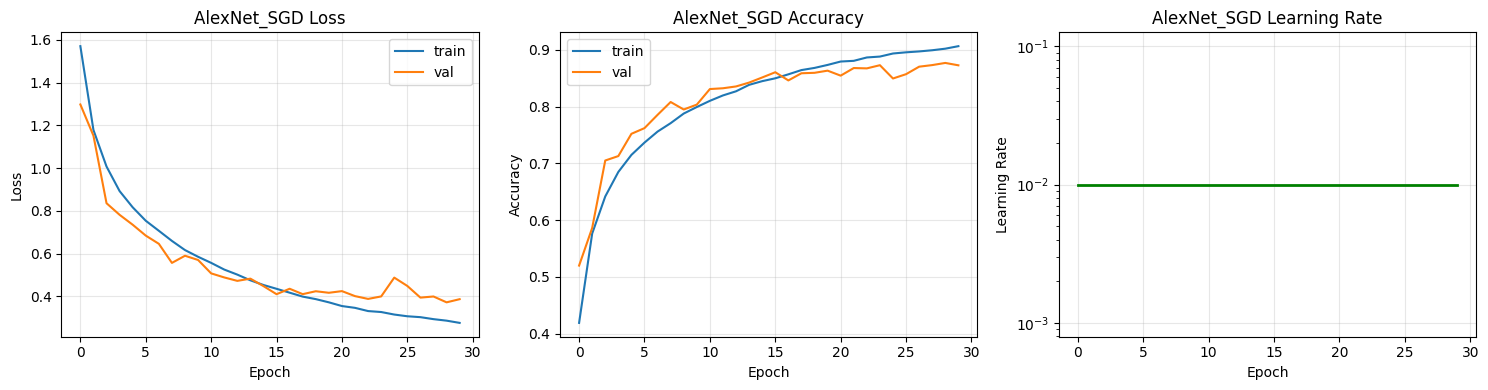

Final test acc: 87.03%
Classification report:
               precision    recall  f1-score   support

    airplane     0.8782    0.8360    0.8566      1000
  automobile     0.9440    0.9440    0.9440      1000
        bird     0.9169    0.7610    0.8317      1000
         cat     0.7759    0.7270    0.7506      1000
        deer     0.8430    0.8910    0.8663      1000
         dog     0.8226    0.8070    0.8147      1000
        frog     0.9029    0.9110    0.9069      1000
       horse     0.8880    0.9280    0.9076      1000
        ship     0.8702    0.9590    0.9125      1000
       truck     0.8638    0.9390    0.8999      1000

    accuracy                         0.8703     10000
   macro avg     0.8705    0.8703    0.8691     10000
weighted avg     0.8705    0.8703    0.8691     10000



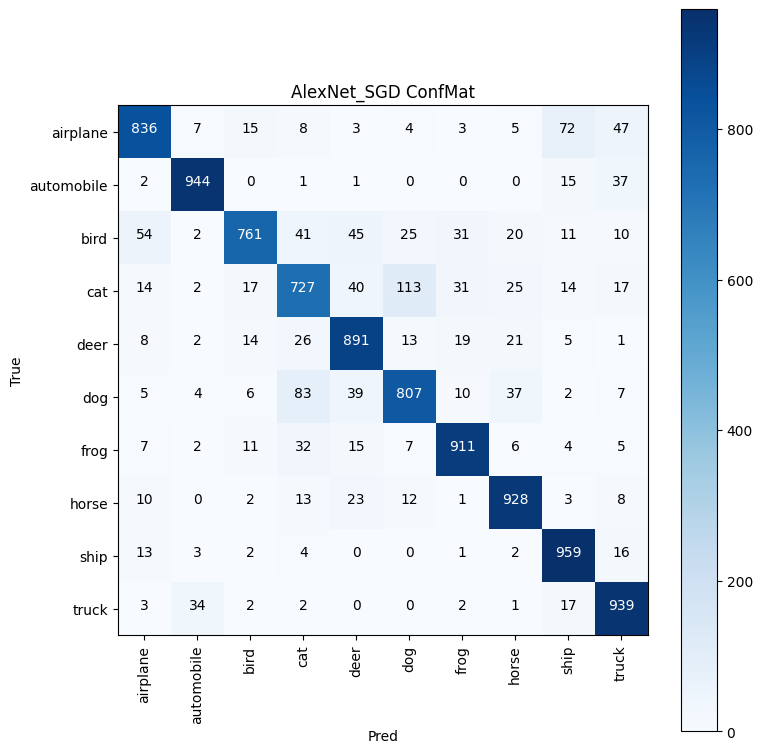

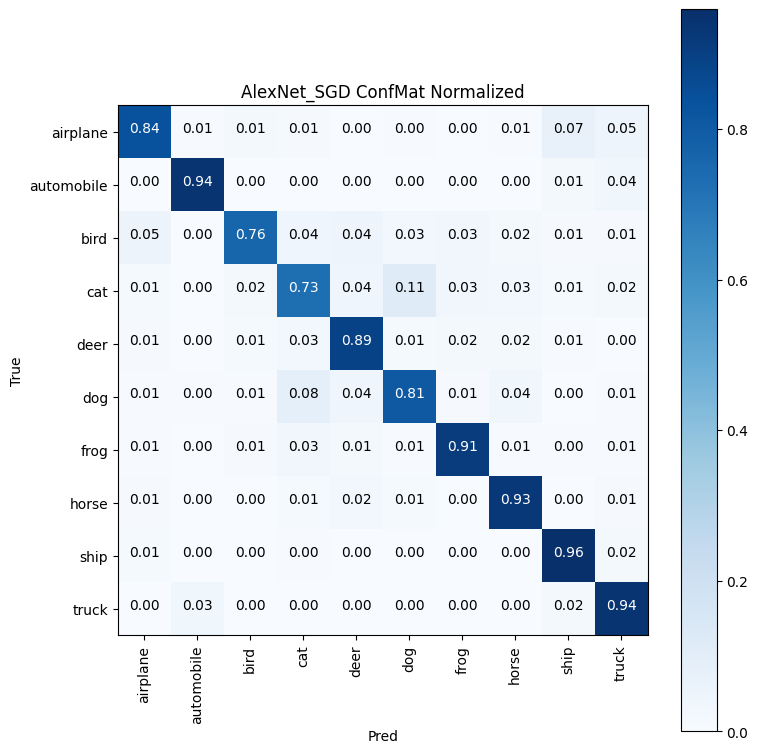

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.9659271205684234e-08..0.9647059102773666].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.05098036231994629..1.0000000532150268].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8882751418036747e-08..1.0000000532150268].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.9659271205684234e-08..0.9372549386024476].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.9659271205684234e-08..0.870588254404068].


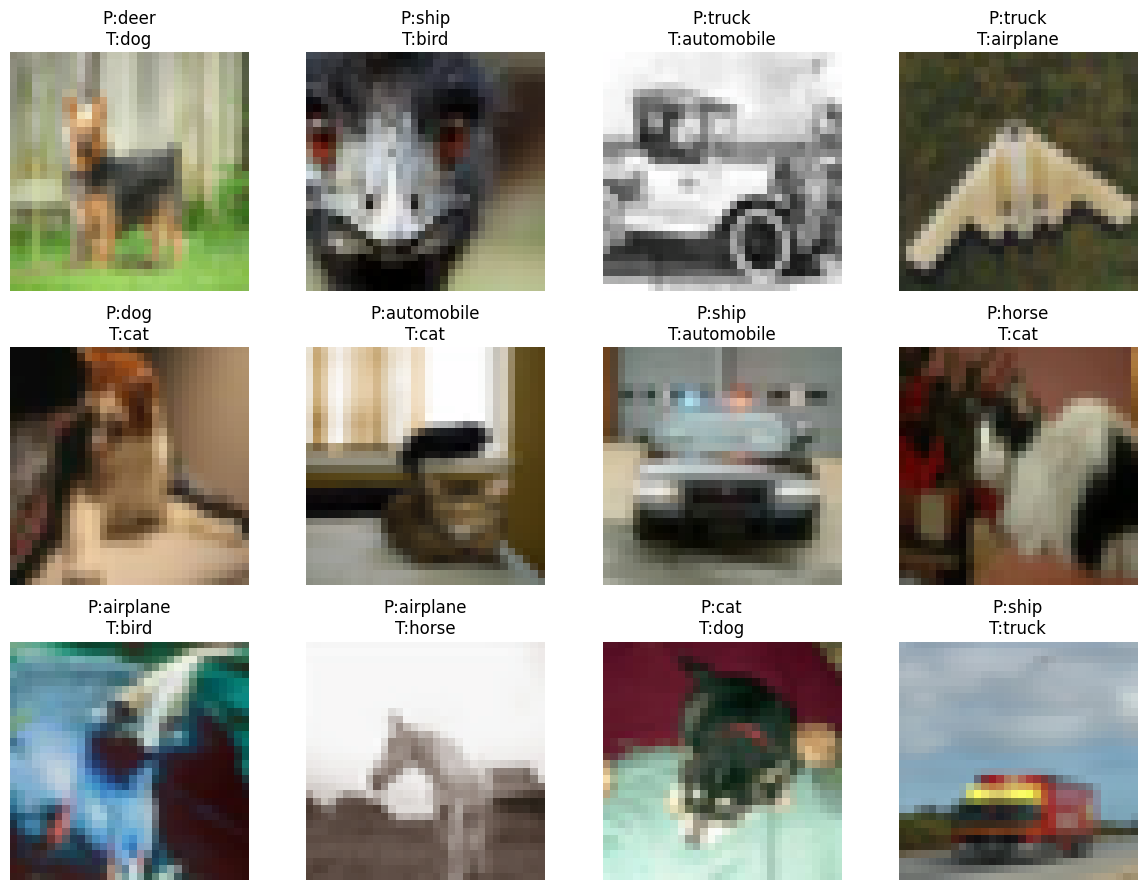

In [11]:
# Run baseline AlexNet with SGD
EPOCHS_BASELINE = 30

simple_model = AlexNetCNN(num_classes=len(classes))
simple_model, simple_history, simple_best = run_experiment(
    model=simple_model,
    model_name="AlexNet_SGD",
    train_loader=train_loader,
    val_loader=val_loader,
    test_loader=test_loader,
    device=DEVICE,
    epochs=EPOCHS_BASELINE,
    optimizer_name="SGD",
    lr=0.01,
    weight_decay=5e-4,
    scheduler_type="StepLR"
)

---

### Experiment 2: VGG11 with Adam Optimizer (Modern Deep Network)

**Experimental Configuration:**
- **Architecture:** VGG11 (128.81 million parameters, pretrained on ImageNet)
- **Optimizer:** Adaptive Moment Estimation (learning rate = 1×10⁻⁴, weight decay = 1×10⁻⁴)
- **Learning Rate Schedule:** ReduceLROnPlateau (patience = 3 epochs, monitors validation loss)
- **Training Duration:** 25 epochs
- **Objective:** Demonstrate performance of modern deep architecture with transfer learning



Downloading: "https://download.pytorch.org/models/vgg11-8a719046.pth" to /home/jupyter-st125970/.cache/torch/hub/checkpoints/vgg11-8a719046.pth


100%|██████████| 507M/507M [01:00<00:00, 8.84MB/s] 


  0%|          | 0/704 [00:00<?, ?it/s]

[VGG11_Adam] Epoch 1/25 | LR 1.00e-04 | train_loss 0.9030 acc 69.15% | val_loss 0.6379 acc 78.62%
Saved best: ./outputs/VGG11_Adam_best.pth


  0%|          | 0/704 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b0d83f5b9c0>
Traceback (most recent call last):
  File "/home/jupyter-st125970/.local/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/home/jupyter-st125970/.local/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/opt/tljh/user/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process


[VGG11_Adam] Epoch 2/25 | LR 1.00e-04 | train_loss 0.5945 acc 80.11% | val_loss 0.5605 acc 81.22%
Saved best: ./outputs/VGG11_Adam_best.pth


  0%|          | 0/704 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b0d83f5b9c0>
Traceback (most recent call last):
  File "/home/jupyter-st125970/.local/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/home/jupyter-st125970/.local/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/opt/tljh/user/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
Exception ignored in:  <function _MultiProcessingDataLoaderIter.__del__ at 0x7b0d83f5b9c0> 
 Traceback (most recent call last):
   File "/home/jupyter-st125970/.local/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1664, in __del__
       self._shutdown_workers() 
   File "/home/jupyter-st125970/.local/lib/python3.12/site-packages/torch/utils/data/dataloader.py", l

[VGG11_Adam] Epoch 3/25 | LR 1.00e-04 | train_loss 0.4895 acc 83.64% | val_loss 0.4826 acc 83.62%
Saved best: ./outputs/VGG11_Adam_best.pth


  0%|          | 0/704 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b0d83f5b9c0>
Traceback (most recent call last):
  File "/home/jupyter-st125970/.local/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/home/jupyter-st125970/.local/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/opt/tljh/user/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           Exception ignored in: ^<function _MultiProcessingDataLoaderIter.__del__ at 0x7b0d83f5b9c0>^
^Traceback (most recent call last):
^  File "/home/jupyter-st125970/.local/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1664, in __del__
^^    ^self._shutdown_workers()^
^  File "/home/jupyter-st125970/.local/lib/python3.12/site-packages/torch/utils/data/datalo

[VGG11_Adam] Epoch 4/25 | LR 1.00e-04 | train_loss 0.4306 acc 85.68% | val_loss 0.4360 acc 85.34%
Saved best: ./outputs/VGG11_Adam_best.pth


  0%|          | 0/704 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b0d83f5b9c0>
Traceback (most recent call last):
  File "/home/jupyter-st125970/.local/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/home/jupyter-st125970/.local/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^Exception ignored in: ^<function _MultiProcessingDataLoaderIter.__del__ at 0x7b0d83f5b9c0>^
^Traceback (most recent call last):

  File "/home/jupyter-st125970/.local/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1664, in __del__
  File "/opt/tljh/user/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
        assert self._parent_pid == os.getpid(), 'can only test a child process'self._shutdown_workers()

   File "/home/jupyter-st125970/.local/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1647

[VGG11_Adam] Epoch 5/25 | LR 1.00e-04 | train_loss 0.3840 acc 86.94% | val_loss 0.4153 acc 86.02%
Saved best: ./outputs/VGG11_Adam_best.pth


  0%|          | 0/704 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b0d83f5b9c0>
Traceback (most recent call last):
  File "/home/jupyter-st125970/.local/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/home/jupyter-st125970/.local/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/opt/tljh/user/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b0d83f5b9c0>
Traceback (most recent call last):
  File "/home/jupyter-st125970/.local/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/home/jupyter

[VGG11_Adam] Epoch 6/25 | LR 1.00e-04 | train_loss 0.3396 acc 88.60% | val_loss 0.3962 acc 86.96%
Saved best: ./outputs/VGG11_Adam_best.pth


  0%|          | 0/704 [00:00<?, ?it/s]

[VGG11_Adam] Epoch 7/25 | LR 1.00e-04 | train_loss 0.3143 acc 89.39% | val_loss 0.3860 acc 87.20%
Saved best: ./outputs/VGG11_Adam_best.pth


  0%|          | 0/704 [00:00<?, ?it/s]

[VGG11_Adam] Epoch 8/25 | LR 1.00e-04 | train_loss 0.2792 acc 90.58% | val_loss 0.4025 acc 87.52%
Saved best: ./outputs/VGG11_Adam_best.pth


  0%|          | 0/704 [00:00<?, ?it/s]

[VGG11_Adam] Epoch 9/25 | LR 1.00e-04 | train_loss 0.2620 acc 91.16% | val_loss 0.3943 acc 87.26%


  0%|          | 0/704 [00:00<?, ?it/s]

[VGG11_Adam] Epoch 10/25 | LR 1.00e-04 | train_loss 0.2387 acc 91.91% | val_loss 0.3582 acc 88.94%
Saved best: ./outputs/VGG11_Adam_best.pth


  0%|          | 0/704 [00:00<?, ?it/s]

[VGG11_Adam] Epoch 11/25 | LR 1.00e-04 | train_loss 0.2194 acc 92.68% | val_loss 0.3957 acc 88.30%


  0%|          | 0/704 [00:00<?, ?it/s]

[VGG11_Adam] Epoch 12/25 | LR 1.00e-04 | train_loss 0.2009 acc 93.36% | val_loss 0.4163 acc 87.36%


  0%|          | 0/704 [00:00<?, ?it/s]

[VGG11_Adam] Epoch 13/25 | LR 1.00e-04 | train_loss 0.1967 acc 93.36% | val_loss 0.3835 acc 88.42%


  0%|          | 0/704 [00:00<?, ?it/s]

[VGG11_Adam] Epoch 14/25 | LR 1.00e-04 | train_loss 0.1805 acc 94.00% | val_loss 0.4001 acc 88.22%


  0%|          | 0/704 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b0d83f5b9c0>
Traceback (most recent call last):
  File "/home/jupyter-st125970/.local/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/home/jupyter-st125970/.local/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^Exception ignored in: ^<function _MultiProcessingDataLoaderIter.__del__ at 0x7b0d83f5b9c0>^

Traceback (most recent call last):
  File "/opt/tljh/user/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
  File "/home/jupyter-st125970/.local/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1664, in __del__
        assert self._parent_pid == os.getpid(), 'can only test a child process'self._shutdown_workers()

   File "/home/jupyter-st125970/.local/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1647

[VGG11_Adam] Epoch 15/25 | LR 1.00e-05 | train_loss 0.1062 acc 96.33% | val_loss 0.3758 acc 89.54%
Saved best: ./outputs/VGG11_Adam_best.pth


  0%|          | 0/704 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b0d83f5b9c0>
Traceback (most recent call last):
  File "/home/jupyter-st125970/.local/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/home/jupyter-st125970/.local/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/opt/tljh/user/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b0d83f5b9c0>
Traceback (most recent call last):
  File "/home/jupyter-st125970/.local/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/home/jupyter

[VGG11_Adam] Epoch 16/25 | LR 1.00e-05 | train_loss 0.0884 acc 97.09% | val_loss 0.3941 acc 89.64%
Saved best: ./outputs/VGG11_Adam_best.pth


  0%|          | 0/704 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b0d83f5b9c0>
Traceback (most recent call last):
  File "/home/jupyter-st125970/.local/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/home/jupyter-st125970/.local/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/opt/tljh/user/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^Exception ignored in: ^<function _MultiProcessingDataLoaderIter.__del__ at 0x7b0d83f5b9c0>^
^Traceback (most recent call last):
^  File "/home/jupyter-st125970/.local/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1664, in __del__
^    
self._shutdown_workers()AssertionError
:   File "/home/jupyter-st125970/.local/lib/python3.1

[VGG11_Adam] Epoch 17/25 | LR 1.00e-05 | train_loss 0.0823 acc 97.22% | val_loss 0.3841 acc 89.86%
Saved best: ./outputs/VGG11_Adam_best.pth


  0%|          | 0/704 [00:00<?, ?it/s]

Exception ignored in: Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x7b0d83f5b9c0>
  File "/home/jupyter-st125970/.local/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/home/jupyter-st125970/.local/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/opt/tljh/user/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
Exception ignored in:     <function _MultiProcessingDataLoaderIter.__del__ at 0x7b0d83f5b9c0>assert self._parent_pid == os.getpid(), 'can only test a child process'

Traceback (most recent call last):
   File "/home/jupyter-st125970/.local/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1664, in __del__
      self._shutdown_workers() 
   File "/home/jupyter-st125970/.local/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 

[VGG11_Adam] Epoch 18/25 | LR 1.00e-05 | train_loss 0.0753 acc 97.50% | val_loss 0.3934 acc 89.58%


  0%|          | 0/704 [00:00<?, ?it/s]

[VGG11_Adam] Epoch 19/25 | LR 1.00e-06 | train_loss 0.0677 acc 97.71% | val_loss 0.3937 acc 89.76%


  0%|          | 0/704 [00:00<?, ?it/s]

[VGG11_Adam] Epoch 20/25 | LR 1.00e-06 | train_loss 0.0661 acc 97.70% | val_loss 0.3974 acc 89.86%


  0%|          | 0/704 [00:00<?, ?it/s]

[VGG11_Adam] Epoch 21/25 | LR 1.00e-06 | train_loss 0.0661 acc 97.77% | val_loss 0.3991 acc 89.88%
Saved best: ./outputs/VGG11_Adam_best.pth


  0%|          | 0/704 [00:00<?, ?it/s]

[VGG11_Adam] Epoch 22/25 | LR 1.00e-06 | train_loss 0.0647 acc 97.80% | val_loss 0.4009 acc 90.04%
Saved best: ./outputs/VGG11_Adam_best.pth


  0%|          | 0/704 [00:00<?, ?it/s]

[VGG11_Adam] Epoch 23/25 | LR 1.00e-07 | train_loss 0.0634 acc 97.90% | val_loss 0.4011 acc 90.04%


  0%|          | 0/704 [00:00<?, ?it/s]

[VGG11_Adam] Epoch 24/25 | LR 1.00e-07 | train_loss 0.0650 acc 97.78% | val_loss 0.4009 acc 90.02%


  0%|          | 0/704 [00:00<?, ?it/s]

[VGG11_Adam] Epoch 25/25 | LR 1.00e-07 | train_loss 0.0631 acc 97.85% | val_loss 0.4008 acc 90.00%


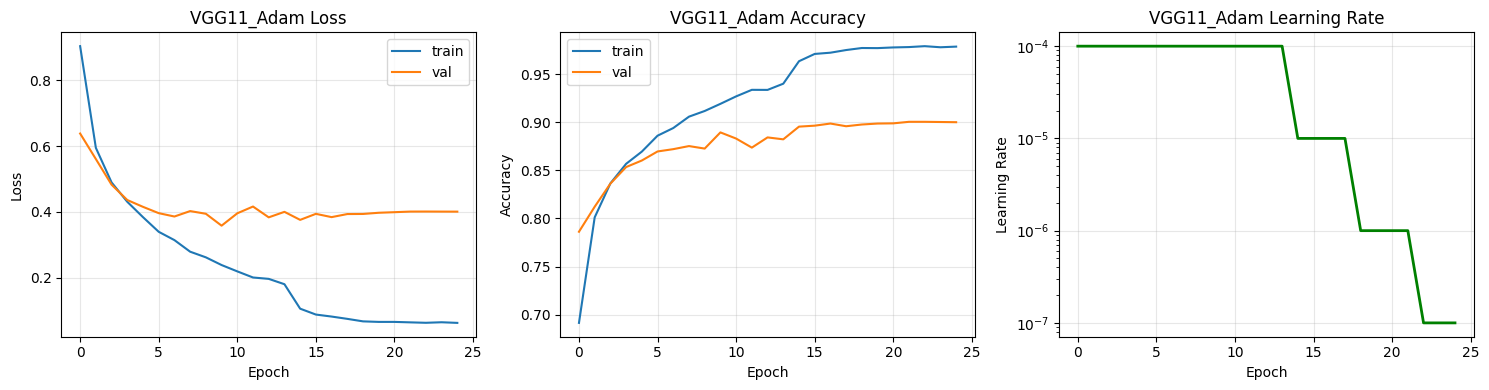

Final test acc: 89.42%
Classification report:
               precision    recall  f1-score   support

    airplane     0.9058    0.9140    0.9099      1000
  automobile     0.9474    0.9540    0.9507      1000
        bird     0.8659    0.8460    0.8558      1000
         cat     0.7861    0.7830    0.7846      1000
        deer     0.8760    0.8900    0.8829      1000
         dog     0.8232    0.8240    0.8236      1000
        frog     0.9228    0.9210    0.9219      1000
       horse     0.9381    0.9250    0.9315      1000
        ship     0.9488    0.9450    0.9469      1000
       truck     0.9270    0.9400    0.9335      1000

    accuracy                         0.8942     10000
   macro avg     0.8941    0.8942    0.8941     10000
weighted avg     0.8941    0.8942    0.8941     10000



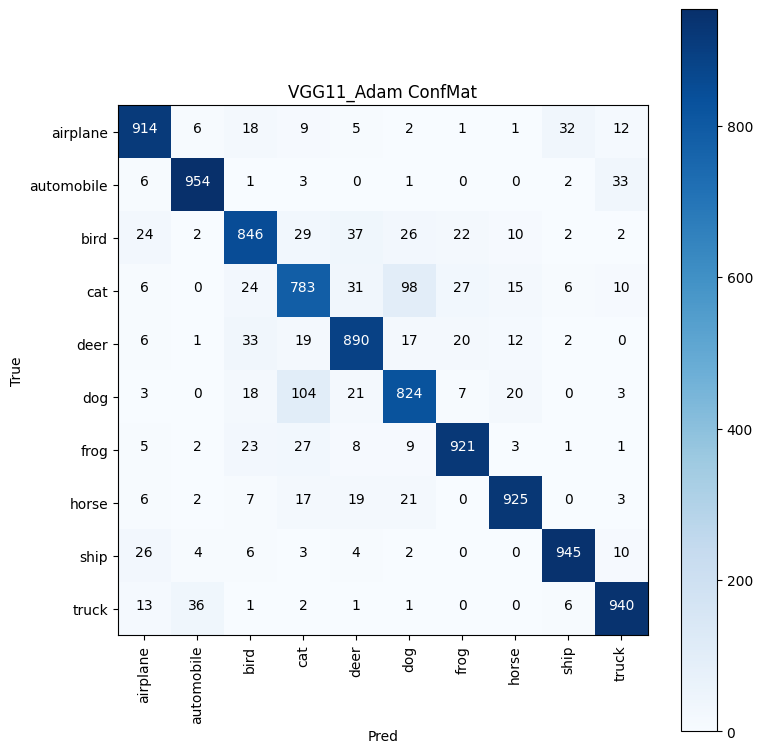

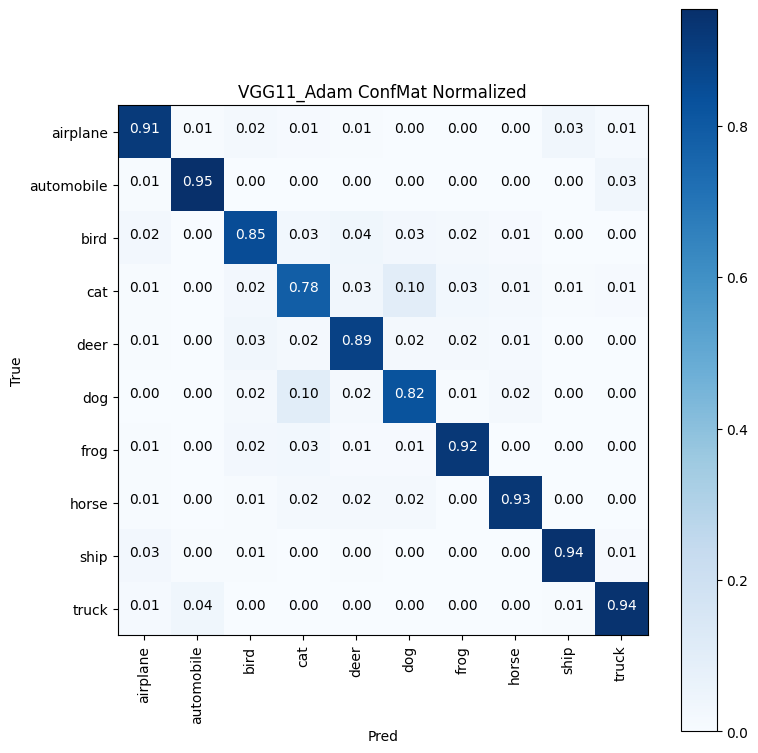

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.9659271205684234e-08..0.9647059102773666].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.05098036231994629..1.0000000532150268].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.9659271205684234e-08..0.941176483297348].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.9659271205684234e-08..0.6313725771725178].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.011764692974090607..1.0000000339984894].


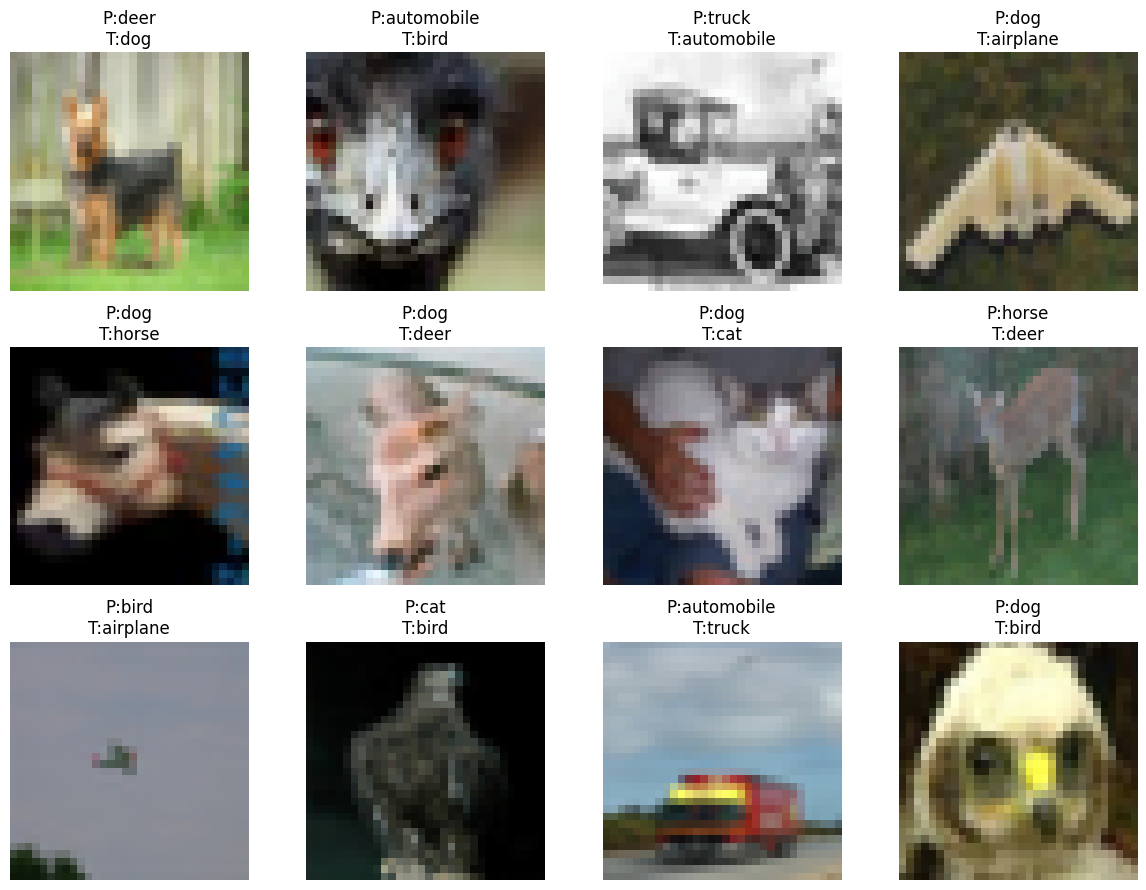

In [12]:
# Run VGG11 (transfer learning) with Adam
EPOCHS_VGG = 25

# NOTE: for VGG on CIFAR (32x32), we keep inputs at 32x32. Optionally, you can upsample to 224x224:
# If you want upsample, replace transforms in train/val/test with Resize(224) + ToTensor + Normalize.

vgg_model = get_vgg11(num_classes=len(classes), pretrained=True, freeze_backbone=False)
vgg_model, vgg_history, vgg_best = run_experiment(
    model=vgg_model,
    model_name="VGG11_Adam",
    train_loader=train_loader,
    val_loader=val_loader,
    test_loader=test_loader,
    device=DEVICE,
    epochs=EPOCHS_VGG,
    optimizer_name="Adam",
    lr=1e-4,
    weight_decay=1e-4,
    scheduler_type="ReduceLROnPlateau"
)

---

### Experiment 3: AlexNet with Adam Optimizer (Controlled Ablation Study)

**Experimental Configuration:**
- **Architecture:** AlexNet-style CNN (2.5 million parameters, identical to Experiment 1)
- **Optimizer:** Adaptive Moment Estimation (learning rate = 1×10⁻³, weight decay = 1×10⁻⁴)
- **Learning Rate Schedule:** ReduceLROnPlateau (patience = 3 epochs)
- **Training Duration:** 30 epochs
- **Objective:** Isolate optimizer effect through controlled comparison with same architecture

**Scientific Justification:**  
Direct comparison between Experiment 1 (AlexNet + SGD) and Experiment 2 (VGG11 + Adam) would confound architectural differences with optimizer differences. This experiment provides a methodologically sound comparison by maintaining architectural parity while varying only the optimization algorithm, thereby enabling causal attribution of performance differences to optimizer choice.


OPTIMIZER COMPARISON: AlexNet with Adam


  0%|          | 0/704 [00:00<?, ?it/s]

[AlexNet_Adam] Epoch 1/30 | LR 1.00e-03 | train_loss 1.6616 acc 37.96% | val_loss 1.2718 acc 53.70%
Saved best: ./outputs/AlexNet_Adam_best.pth


  0%|          | 0/704 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b0d83f5b9c0>
Traceback (most recent call last):
  File "/home/jupyter-st125970/.local/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/home/jupyter-st125970/.local/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
      Exception ignored in:  <function _MultiProcessingDataLoaderIter.__del__ at 0x7b0d83f5b9c0>^
^Traceback (most recent call last):
^  File "/home/jupyter-st125970/.local/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1664, in __del__
^    ^self._shutdown_workers()^
^  File "/home/jupyter-st125970/.local/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
^    ^if w.is_alive():^
^ ^ 
   File "/opt/tljh/user/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
      assert self._parent_pid 

[AlexNet_Adam] Epoch 2/30 | LR 1.00e-03 | train_loss 1.2917 acc 53.44% | val_loss 1.2258 acc 54.96%
Saved best: ./outputs/AlexNet_Adam_best.pth


  0%|          | 0/704 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b0d83f5b9c0>
Traceback (most recent call last):
  File "/home/jupyter-st125970/.local/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/home/jupyter-st125970/.local/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/opt/tljh/user/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b0d83f5b9c0>Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7b0d83f5b9c0>Traceback (most recent call last):

  File "/home/jupyter-st125970/.local/lib/python3.12/site-packages/torch/utils/dat

[AlexNet_Adam] Epoch 3/30 | LR 1.00e-03 | train_loss 1.1028 acc 60.76% | val_loss 0.8982 acc 69.54%
Saved best: ./outputs/AlexNet_Adam_best.pth


  0%|          | 0/704 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b0d83f5b9c0>
Traceback (most recent call last):
  File "/home/jupyter-st125970/.local/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/home/jupyter-st125970/.local/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7b0d83f5b9c0> 
 Traceback (most recent call last):
   File "/home/jupyter-st125970/.local/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1664, in __del__
      self._shutdown_workers() 
 ^  File "/home/jupyter-st125970/.local/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
^^    ^if w.is_alive():
^ ^ ^ ^ ^ ^ ^ ^^
^  File "/opt/tljh/user/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
^    ^assert self._paren

[AlexNet_Adam] Epoch 4/30 | LR 1.00e-03 | train_loss 0.9792 acc 65.95% | val_loss 0.8284 acc 71.16%
Saved best: ./outputs/AlexNet_Adam_best.pth


  0%|          | 0/704 [00:00<?, ?it/s]

[AlexNet_Adam] Epoch 5/30 | LR 1.00e-03 | train_loss 0.8808 acc 69.48% | val_loss 0.7655 acc 74.16%
Saved best: ./outputs/AlexNet_Adam_best.pth


  0%|          | 0/704 [00:00<?, ?it/s]

[AlexNet_Adam] Epoch 6/30 | LR 1.00e-03 | train_loss 0.8081 acc 72.43% | val_loss 0.7157 acc 75.00%
Saved best: ./outputs/AlexNet_Adam_best.pth


  0%|          | 0/704 [00:00<?, ?it/s]

[AlexNet_Adam] Epoch 7/30 | LR 1.00e-03 | train_loss 0.7519 acc 74.81% | val_loss 0.7208 acc 75.70%
Saved best: ./outputs/AlexNet_Adam_best.pth


  0%|          | 0/704 [00:00<?, ?it/s]

[AlexNet_Adam] Epoch 8/30 | LR 1.00e-03 | train_loss 0.7025 acc 76.51% | val_loss 0.6232 acc 78.78%
Saved best: ./outputs/AlexNet_Adam_best.pth


  0%|          | 0/704 [00:00<?, ?it/s]

[AlexNet_Adam] Epoch 9/30 | LR 1.00e-03 | train_loss 0.6552 acc 78.34% | val_loss 0.6368 acc 79.36%
Saved best: ./outputs/AlexNet_Adam_best.pth


  0%|          | 0/704 [00:00<?, ?it/s]

[AlexNet_Adam] Epoch 10/30 | LR 1.00e-03 | train_loss 0.6175 acc 79.45% | val_loss 0.5310 acc 81.56%
Saved best: ./outputs/AlexNet_Adam_best.pth


  0%|          | 0/704 [00:00<?, ?it/s]

[AlexNet_Adam] Epoch 11/30 | LR 1.00e-03 | train_loss 0.5875 acc 80.48% | val_loss 0.5939 acc 80.38%


  0%|          | 0/704 [00:00<?, ?it/s]

[AlexNet_Adam] Epoch 12/30 | LR 1.00e-03 | train_loss 0.5576 acc 81.64% | val_loss 0.5076 acc 83.50%
Saved best: ./outputs/AlexNet_Adam_best.pth


  0%|          | 0/704 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b0d83f5b9c0>
Traceback (most recent call last):
  File "/home/jupyter-st125970/.local/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/home/jupyter-st125970/.local/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^Exception ignored in: ^<function _MultiProcessingDataLoaderIter.__del__ at 0x7b0d83f5b9c0>^
^Traceback (most recent call last):
^  File "/home/jupyter-st125970/.local/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1664, in __del__
^    ^self._shutdown_workers()^
^  File "/home/jupyter-st125970/.local/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
^    
if w.is_alive():  File "/opt/tljh/user/lib/python3.12/multiprocessing/process.py", line 160, in is_alive

     assert self._parent_pid == o

[AlexNet_Adam] Epoch 13/30 | LR 1.00e-03 | train_loss 0.5321 acc 82.40% | val_loss 0.5115 acc 82.36%


  0%|          | 0/704 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b0d83f5b9c0>Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7b0d83f5b9c0>Traceback (most recent call last):

  File "/home/jupyter-st125970/.local/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1664, in __del__
Traceback (most recent call last):
  File "/home/jupyter-st125970/.local/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()    
self._shutdown_workers()  File "/home/jupyter-st125970/.local/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers

  File "/home/jupyter-st125970/.local/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():    
if w.is_alive(): 
            ^^ ^^^^^^^^^^^^^^^^^^^
^  File "/opt/tljh/user/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
^    ^assert sel

[AlexNet_Adam] Epoch 14/30 | LR 1.00e-03 | train_loss 0.4979 acc 83.44% | val_loss 0.5204 acc 82.86%


  0%|          | 0/704 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b0d83f5b9c0>
Traceback (most recent call last):
  File "/home/jupyter-st125970/.local/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    Exception ignored in: self._shutdown_workers()<function _MultiProcessingDataLoaderIter.__del__ at 0x7b0d83f5b9c0>

  File "/home/jupyter-st125970/.local/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
Traceback (most recent call last):
      File "/home/jupyter-st125970/.local/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1664, in __del__
if w.is_alive():    
self._shutdown_workers() 
   File "/home/jupyter-st125970/.local/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
       if w.is_alive(): 
  ^ ^ ^ ^ ^ ^ ^^^^^^^^^^^^
  File "/opt/tljh/user/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
^    ^assert self._p

[AlexNet_Adam] Epoch 15/30 | LR 1.00e-03 | train_loss 0.4884 acc 84.04% | val_loss 0.4880 acc 84.46%
Saved best: ./outputs/AlexNet_Adam_best.pth


  0%|          | 0/704 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b0d83f5b9c0>
Traceback (most recent call last):
  File "/home/jupyter-st125970/.local/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/home/jupyter-st125970/.local/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/opt/tljh/user/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b0d83f5b9c0>
Traceback (most recent call last):
  File "/home/jupyter-st125970/.local/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/home/jupyter

[AlexNet_Adam] Epoch 16/30 | LR 1.00e-03 | train_loss 0.4733 acc 84.52% | val_loss 0.5278 acc 83.48%


  0%|          | 0/704 [00:00<?, ?it/s]

[AlexNet_Adam] Epoch 17/30 | LR 1.00e-03 | train_loss 0.4602 acc 84.87% | val_loss 0.5532 acc 82.68%


  0%|          | 0/704 [00:00<?, ?it/s]

[AlexNet_Adam] Epoch 18/30 | LR 1.00e-03 | train_loss 0.4356 acc 85.65% | val_loss 0.4343 acc 85.70%
Saved best: ./outputs/AlexNet_Adam_best.pth


  0%|          | 0/704 [00:00<?, ?it/s]

[AlexNet_Adam] Epoch 19/30 | LR 1.00e-03 | train_loss 0.4274 acc 85.94% | val_loss 0.5457 acc 82.12%


  0%|          | 0/704 [00:00<?, ?it/s]

[AlexNet_Adam] Epoch 20/30 | LR 1.00e-03 | train_loss 0.4143 acc 86.29% | val_loss 0.4593 acc 85.44%


  0%|          | 0/704 [00:00<?, ?it/s]

[AlexNet_Adam] Epoch 21/30 | LR 1.00e-03 | train_loss 0.3997 acc 86.95% | val_loss 0.4973 acc 83.46%


  0%|          | 0/704 [00:00<?, ?it/s]

[AlexNet_Adam] Epoch 22/30 | LR 1.00e-03 | train_loss 0.3930 acc 87.07% | val_loss 0.5741 acc 82.94%


  0%|          | 0/704 [00:00<?, ?it/s]

[AlexNet_Adam] Epoch 23/30 | LR 1.00e-04 | train_loss 0.2778 acc 90.70% | val_loss 0.3499 acc 88.86%
Saved best: ./outputs/AlexNet_Adam_best.pth


  0%|          | 0/704 [00:00<?, ?it/s]

[AlexNet_Adam] Epoch 24/30 | LR 1.00e-04 | train_loss 0.2369 acc 92.08% | val_loss 0.3559 acc 89.16%
Saved best: ./outputs/AlexNet_Adam_best.pth


  0%|          | 0/704 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b0d83f5b9c0>
Traceback (most recent call last):
  File "/home/jupyter-st125970/.local/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/home/jupyter-st125970/.local/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
 Exception ignored in:  <function _MultiProcessingDataLoaderIter.__del__ at 0x7b0d83f5b9c0> 
 Traceback (most recent call last):
   File "/home/jupyter-st125970/.local/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1664, in __del__
      self._shutdown_workers()^
^  File "/home/jupyter-st125970/.local/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
^    ^if w.is_alive():^
^^ ^ ^ ^ ^ ^ 
   File "/opt/tljh/user/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
^    ^assert self._parent_

[AlexNet_Adam] Epoch 25/30 | LR 1.00e-04 | train_loss 0.2209 acc 92.69% | val_loss 0.3485 acc 89.64%
Saved best: ./outputs/AlexNet_Adam_best.pth


  0%|          | 0/704 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b0d83f5b9c0>
Traceback (most recent call last):
  File "/home/jupyter-st125970/.local/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/home/jupyter-st125970/.local/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/opt/tljh/user/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^Exception ignored in: ^<function _MultiProcessingDataLoaderIter.__del__ at 0x7b0d83f5b9c0>^
^Traceback (most recent call last):
^  File "/home/jupyter-st125970/.local/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1664, in __del__
^
    AssertionErrorself._shutdown_workers(): 
can only test a child process  File "/home/jupyter-

[AlexNet_Adam] Epoch 26/30 | LR 1.00e-04 | train_loss 0.2065 acc 93.15% | val_loss 0.3434 acc 89.52%


  0%|          | 0/704 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b0d83f5b9c0>
Traceback (most recent call last):
  File "/home/jupyter-st125970/.local/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/home/jupyter-st125970/.local/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
      Exception ignored in:  <function _MultiProcessingDataLoaderIter.__del__ at 0x7b0d83f5b9c0>^
^Traceback (most recent call last):
^  File "/home/jupyter-st125970/.local/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1664, in __del__
^^    ^self._shutdown_workers()^
^  File "/home/jupyter-st125970/.local/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
^^    ^if w.is_alive():^

   File "/opt/tljh/user/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
      assert self._parent_pid ==

[AlexNet_Adam] Epoch 27/30 | LR 1.00e-04 | train_loss 0.2004 acc 93.20% | val_loss 0.3439 acc 89.70%
Saved best: ./outputs/AlexNet_Adam_best.pth


  0%|          | 0/704 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b0d83f5b9c0>
Traceback (most recent call last):
  File "/home/jupyter-st125970/.local/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/home/jupyter-st125970/.local/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/opt/tljh/user/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b0d83f5b9c0>
Traceback (most recent call last):
  File "/home/jupyter-st125970/.local/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/home/jupyter

[AlexNet_Adam] Epoch 28/30 | LR 1.00e-04 | train_loss 0.1877 acc 93.56% | val_loss 0.3466 acc 89.10%


  0%|          | 0/704 [00:00<?, ?it/s]

[AlexNet_Adam] Epoch 29/30 | LR 1.00e-04 | train_loss 0.1825 acc 93.89% | val_loss 0.3600 acc 89.76%
Saved best: ./outputs/AlexNet_Adam_best.pth


  0%|          | 0/704 [00:00<?, ?it/s]

[AlexNet_Adam] Epoch 30/30 | LR 1.00e-04 | train_loss 0.1766 acc 94.12% | val_loss 0.3526 acc 89.48%


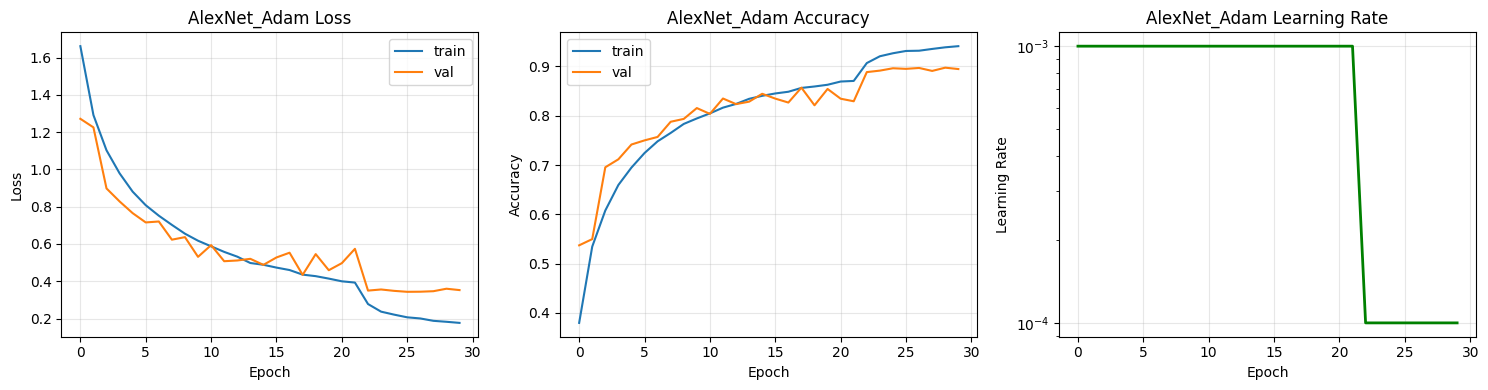

Final test acc: 89.31%
Classification report:
               precision    recall  f1-score   support

    airplane     0.8878    0.9100    0.8988      1000
  automobile     0.9516    0.9440    0.9478      1000
        bird     0.8797    0.8410    0.8599      1000
         cat     0.7874    0.7850    0.7862      1000
        deer     0.9117    0.8780    0.8945      1000
         dog     0.8539    0.8240    0.8387      1000
        frog     0.8882    0.9450    0.9157      1000
       horse     0.9029    0.9480    0.9249      1000
        ship     0.9459    0.9270    0.9364      1000
       truck     0.9216    0.9290    0.9253      1000

    accuracy                         0.8931     10000
   macro avg     0.8931    0.8931    0.8928     10000
weighted avg     0.8931    0.8931    0.8928     10000



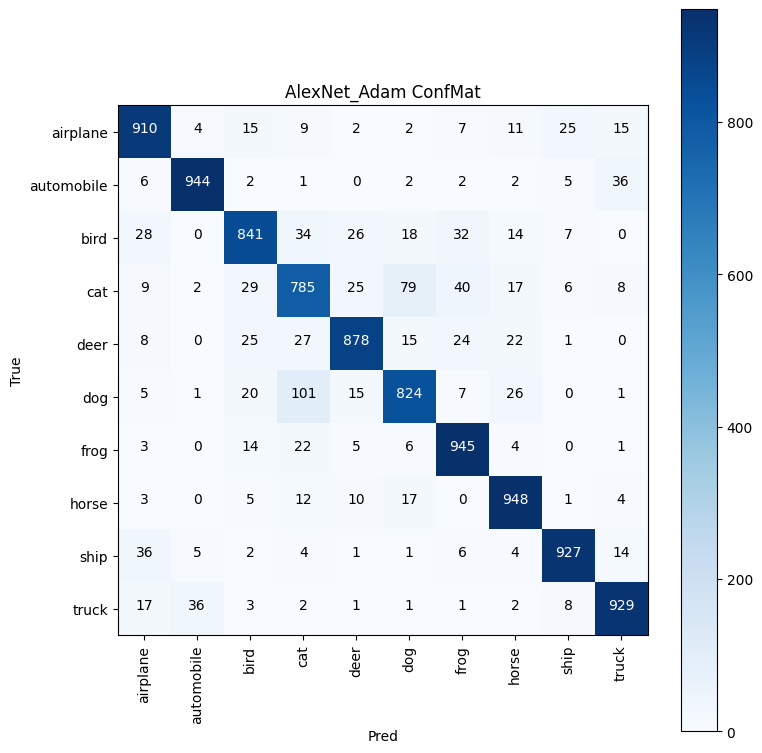

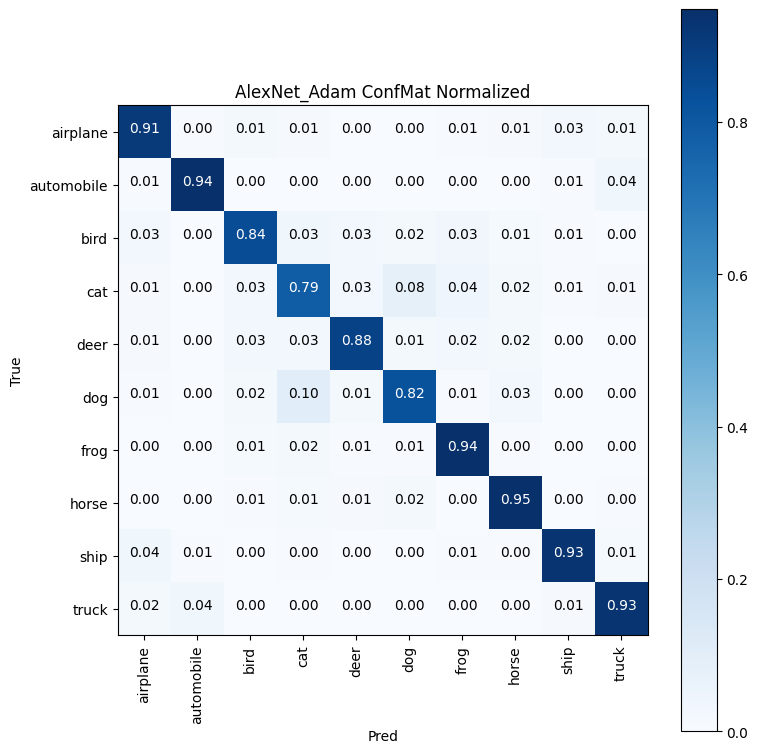

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.9659271205684234e-08..1.0000000532150268].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.9659271205684234e-08..0.9921568327665329].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.9659271205684234e-08..0.9647059102773666].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.05098036231994629..1.0000000532150268].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8882751418036747e-08..1.0000000532150268].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.9659271205684234e-08..0.988235330581665].


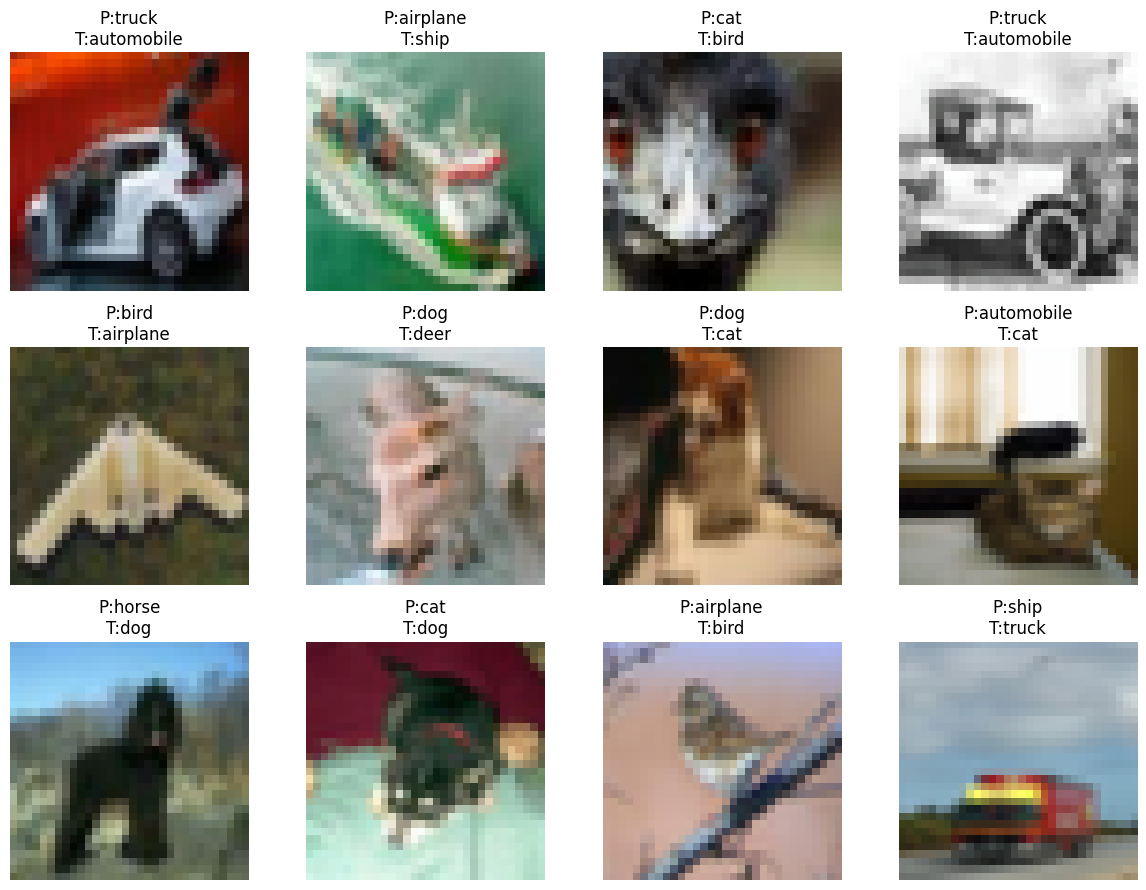

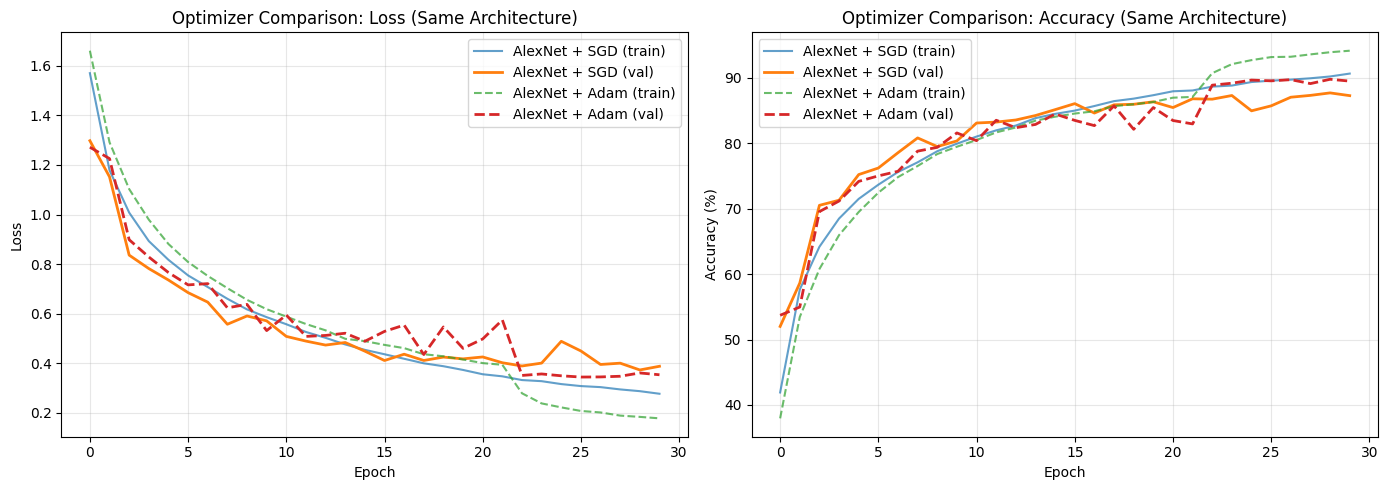


AlexNet + SGD  -> Best Val Acc: 87.68%
AlexNet + Adam -> Best Val Acc: 89.76%


In [13]:
# To properly compare SGD vs Adam, we need to test the same architecture with both optimizers
# This isolates the optimizer effect from architecture differences

print("=" * 60)
print("OPTIMIZER COMPARISON: AlexNet with Adam")
print("=" * 60)

alexnet_adam = AlexNetCNN(num_classes=len(classes))
alexnet_adam, alexnet_adam_history, alexnet_adam_best = run_experiment(
    model=alexnet_adam,
    model_name="AlexNet_Adam",
    train_loader=train_loader,
    val_loader=val_loader,
    test_loader=test_loader,
    device=DEVICE,
    epochs=EPOCHS_BASELINE,
    optimizer_name="Adam",
    lr=1e-3,
    weight_decay=1e-4,
    scheduler_type="ReduceLROnPlateau"
)

# Compare AlexNet with SGD vs Adam
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(simple_history['train_loss'], label='AlexNet + SGD (train)', alpha=0.7)
plt.plot(simple_history['val_loss'], label='AlexNet + SGD (val)', linewidth=2)
plt.plot(alexnet_adam_history['train_loss'], label='AlexNet + Adam (train)', alpha=0.7, linestyle='--')
plt.plot(alexnet_adam_history['val_loss'], label='AlexNet + Adam (val)', linewidth=2, linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Optimizer Comparison: Loss (Same Architecture)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot([x*100 for x in simple_history['train_acc']], label='AlexNet + SGD (train)', alpha=0.7)
plt.plot([x*100 for x in simple_history['val_acc']], label='AlexNet + SGD (val)', linewidth=2)
plt.plot([x*100 for x in alexnet_adam_history['train_acc']], label='AlexNet + Adam (train)', alpha=0.7, linestyle='--')
plt.plot([x*100 for x in alexnet_adam_history['val_acc']], label='AlexNet + Adam (val)', linewidth=2, linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Optimizer Comparison: Accuracy (Same Architecture)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "optimizer_comparison_ablation.png"), dpi=150)
plt.show()

print("\n" + "="*60)
print(f"AlexNet + SGD  -> Best Val Acc: {max(simple_history['val_acc'])*100:.2f}%")
print(f"AlexNet + Adam -> Best Val Acc: {max(alexnet_adam_history['val_acc'])*100:.2f}%")
print("="*60)

---

## Section 6: Comparative Performance Analysis

### Architecture Comparison: AlexNet versus VGG11

This section generates comprehensive comparative visualizations to analyze differences in model performance and training dynamics.

**Analysis Dimensions:**
- **Training and Validation Loss Trajectories** - Convergence speed and optimization stability
- **Training and Validation Accuracy Progression** - Learning effectiveness over training epochs
- **Generalization Gap Analysis** - Difference between training and validation performance (overfitting assessment)
- **Convergence Speed Comparison** - Number of epochs required to reach specific performance thresholds


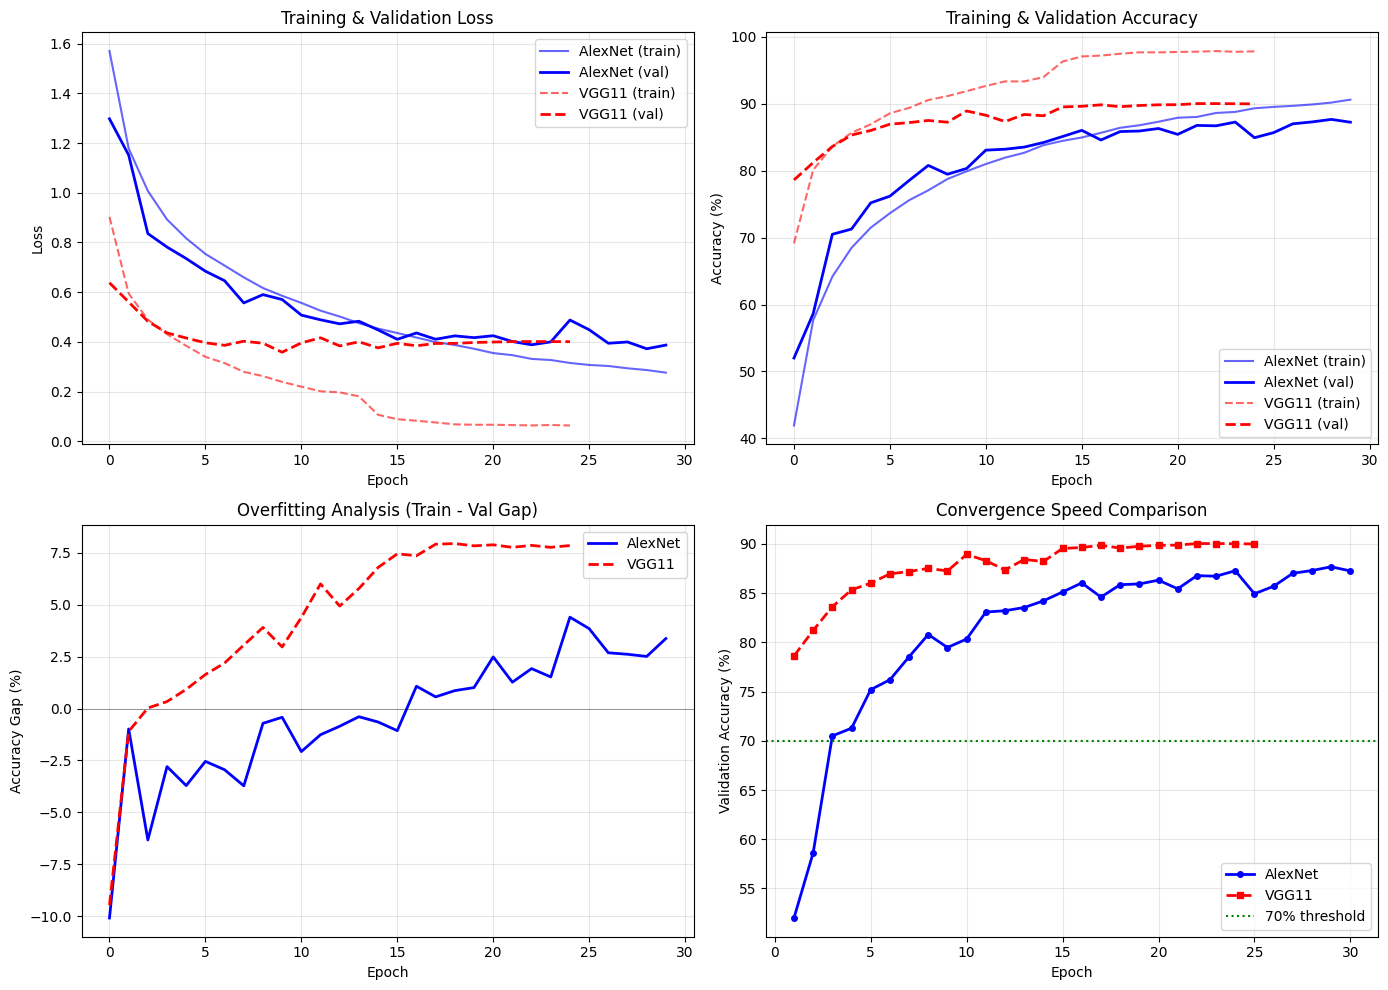


ARCHITECTURE COMPARISON SUMMARY
Metric                                 AlexNet           VGG11
----------------------------------------------------------------------
Best Val Accuracy                       87.68%          90.04%
Final Train Accuracy                    90.63%          97.85%
Final Overfitting Gap                    3.37%           7.85%
Epochs to 70% Val Acc                        3               1


In [14]:
# Side-by-side comparison of both architectures
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Loss comparison
axes[0, 0].plot(simple_history['train_loss'], label='AlexNet (train)', color='blue', alpha=0.6)
axes[0, 0].plot(simple_history['val_loss'], label='AlexNet (val)', color='blue', linewidth=2)
axes[0, 0].plot(vgg_history['train_loss'], label='VGG11 (train)', color='red', alpha=0.6, linestyle='--')
axes[0, 0].plot(vgg_history['val_loss'], label='VGG11 (val)', color='red', linewidth=2, linestyle='--')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].set_title('Training & Validation Loss')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Accuracy comparison
axes[0, 1].plot([x*100 for x in simple_history['train_acc']], label='AlexNet (train)', color='blue', alpha=0.6)
axes[0, 1].plot([x*100 for x in simple_history['val_acc']], label='AlexNet (val)', color='blue', linewidth=2)
axes[0, 1].plot([x*100 for x in vgg_history['train_acc']], label='VGG11 (train)', color='red', alpha=0.6, linestyle='--')
axes[0, 1].plot([x*100 for x in vgg_history['val_acc']], label='VGG11 (val)', color='red', linewidth=2, linestyle='--')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy (%)')
axes[0, 1].set_title('Training & Validation Accuracy')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Overfitting analysis (train-val gap)
simple_gap = [train - val for train, val in zip(simple_history['train_acc'], simple_history['val_acc'])]
vgg_gap = [train - val for train, val in zip(vgg_history['train_acc'], vgg_history['val_acc'])]
axes[1, 0].plot([x*100 for x in simple_gap], label='AlexNet', color='blue', linewidth=2)
axes[1, 0].plot([x*100 for x in vgg_gap], label='VGG11', color='red', linewidth=2, linestyle='--')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Accuracy Gap (%)')
axes[1, 0].set_title('Overfitting Analysis (Train - Val Gap)')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].axhline(y=0, color='black', linestyle='-', linewidth=0.5, alpha=0.5)

# Convergence speed (epochs to reach 70% val acc)
epochs_range = range(1, len(simple_history['val_acc']) + 1)
axes[1, 1].plot(epochs_range, [x*100 for x in simple_history['val_acc']], 
                label='AlexNet', color='blue', linewidth=2, marker='o', markersize=4)
axes[1, 1].plot(range(1, len(vgg_history['val_acc']) + 1), [x*100 for x in vgg_history['val_acc']], 
                label='VGG11', color='red', linewidth=2, marker='s', markersize=4, linestyle='--')
axes[1, 1].axhline(y=70, color='green', linestyle=':', linewidth=1.5, label='70% threshold')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Validation Accuracy (%)')
axes[1, 1].set_title('Convergence Speed Comparison')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "architecture_comparison_full.png"), dpi=150)
plt.show()

# Print summary statistics
print("\n" + "="*70)
print("ARCHITECTURE COMPARISON SUMMARY")
print("="*70)
print(f"{'Metric':<30} {'AlexNet':>15} {'VGG11':>15}")
print("-"*70)
print(f"{'Best Val Accuracy':<30} {max(simple_history['val_acc'])*100:>14.2f}% {max(vgg_history['val_acc'])*100:>14.2f}%")
print(f"{'Final Train Accuracy':<30} {simple_history['train_acc'][-1]*100:>14.2f}% {vgg_history['train_acc'][-1]*100:>14.2f}%")
print(f"{'Final Overfitting Gap':<30} {(simple_history['train_acc'][-1] - simple_history['val_acc'][-1])*100:>14.2f}% {(vgg_history['train_acc'][-1] - vgg_history['val_acc'][-1])*100:>14.2f}%")
print(f"{'Epochs to 70% Val Acc':<30} {next((i+1 for i, v in enumerate(simple_history['val_acc']) if v >= 0.70), 'N/A'):>15} {next((i+1 for i, v in enumerate(vgg_history['val_acc']) if v >= 0.70), 'N/A'):>15}")
print("="*70)

---

### Artifact Preservation and Storage
This section saves all training artifacts, model checkpoints, and experimental results for future analysis, reproducibility, and archival purposes.

**Outputs Saved to Storage:**
- Training history dictionaries serialized in JSON format
- Best model checkpoints in PyTorch state dictionary format (.pth files)
- All visualization figures in portable network graphics format (saved to ./outputs/ directory)


In [17]:
# Save final artifacts
import json
artifacts = {
    "alexnet_history": simple_history,
    "vgg11_history": vgg_history,
    "alexnet_adam_history": alexnet_adam_history
}
with open(os.path.join(OUT_DIR, "histories.json"), "w") as f:
    json.dump(artifacts, f)
print("Saved histories ->", os.path.join(OUT_DIR, "histories.json"))
print("Best models saved under outputs/ (filenames contain model names).")

Saved histories -> ./outputs/histories.json
Best models saved under outputs/ (filenames contain model names).


---

## Section 7: Activation Map Visualization and Feature Learning Analysis

### Convolutional Feature Visualization
This section visualizes intermediate feature representations learned by convolutional layers to provide insight into the hierarchical feature learning process of each architecture.

**Layers Selected for Analysis:**
- **AlexNet-style CNN:** First convolutional layer (features.0) and second convolutional block (features.4)
- **VGG11:** First convolutional layer (features.0) and layer after first pooling (features.5)

**Expected Observations:**
- **Layer 1 (Early Features):** Low-level visual features including edge detectors, color gradients, and simple oriented patterns
- **Layer 2 (Mid-Level Features):** Intermediate features such as texture patterns, corner detectors, and simple geometric shapes
- **Architectural Differences:** VGG11 expected to show more diverse and semantically meaningful feature detectors due to ImageNet pretraining, while AlexNet learns task-specific features from scratch


Extracting activation maps from VGG11 layers: ['features.0', 'features.5']


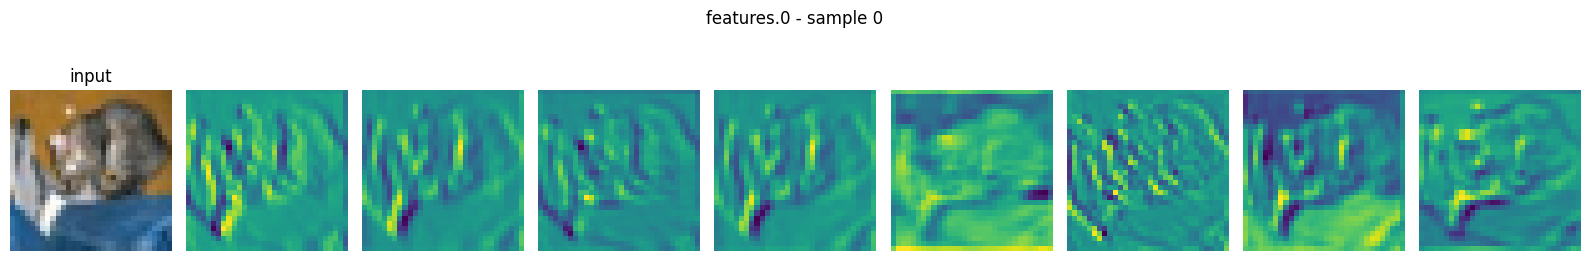

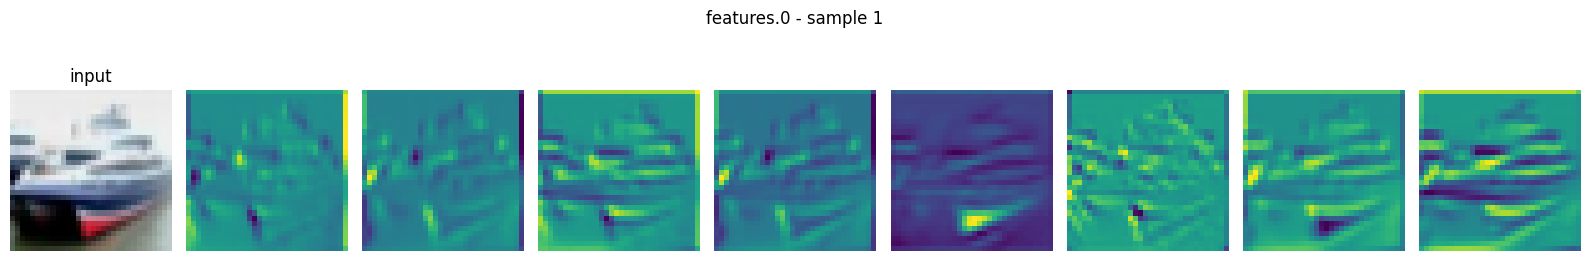

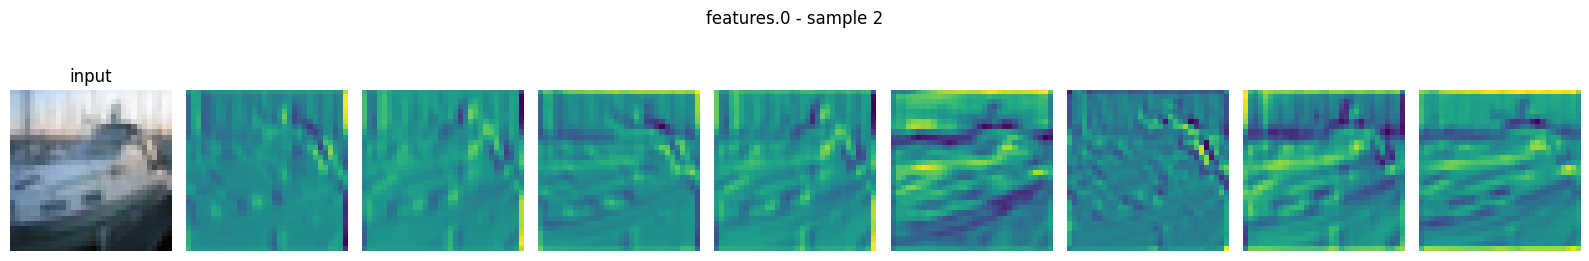

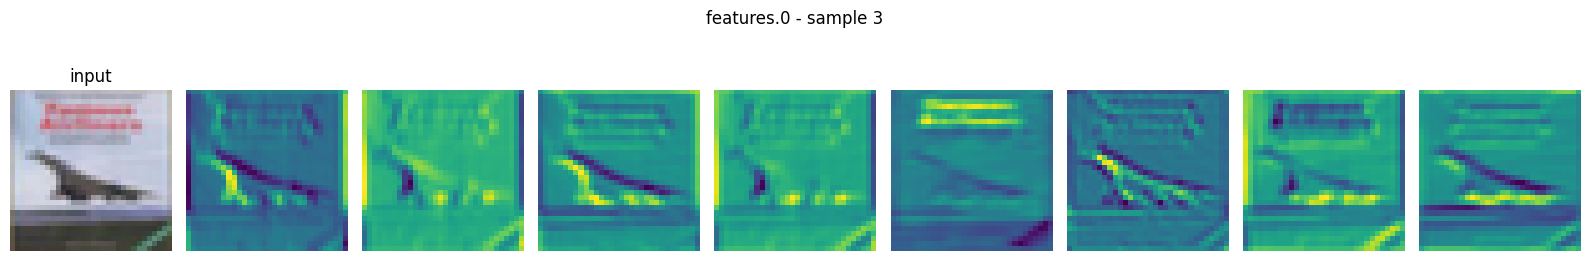

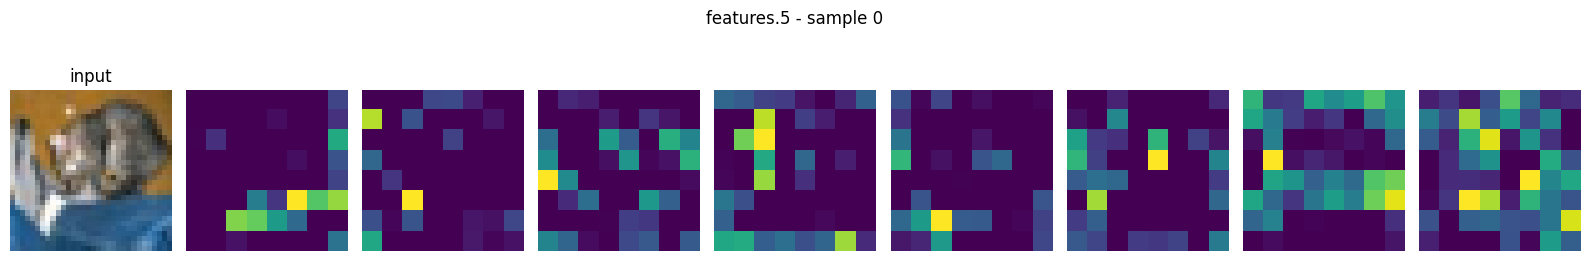

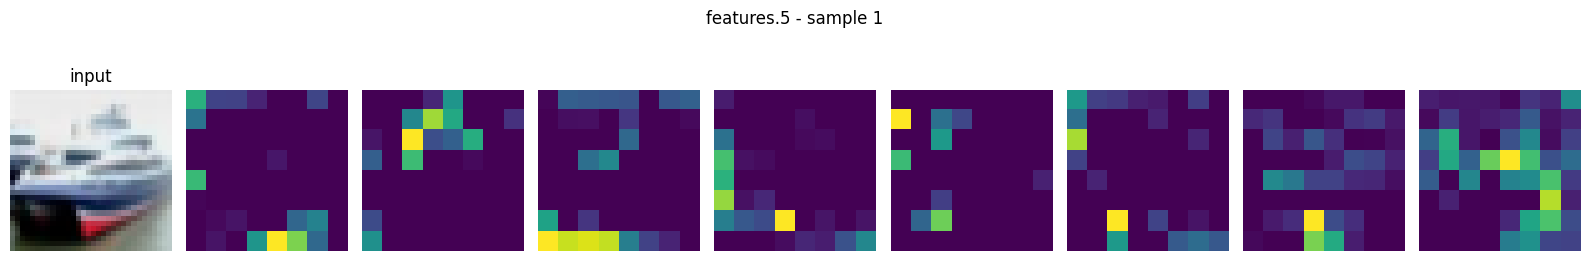

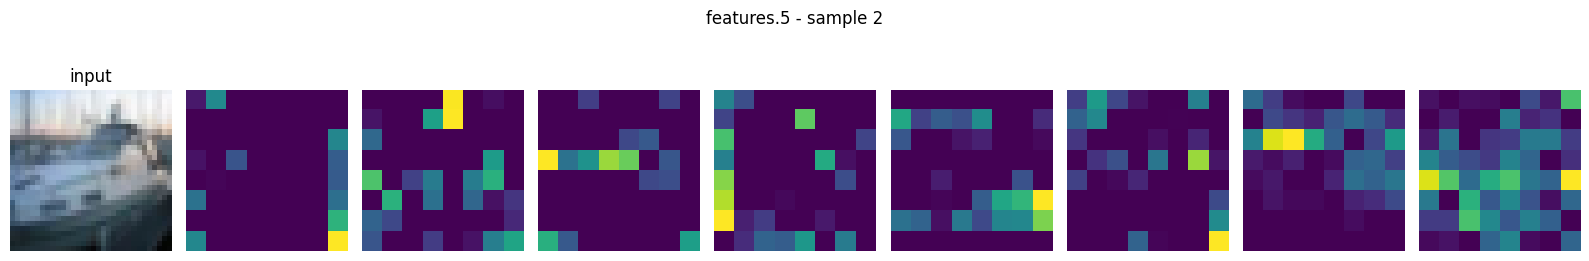

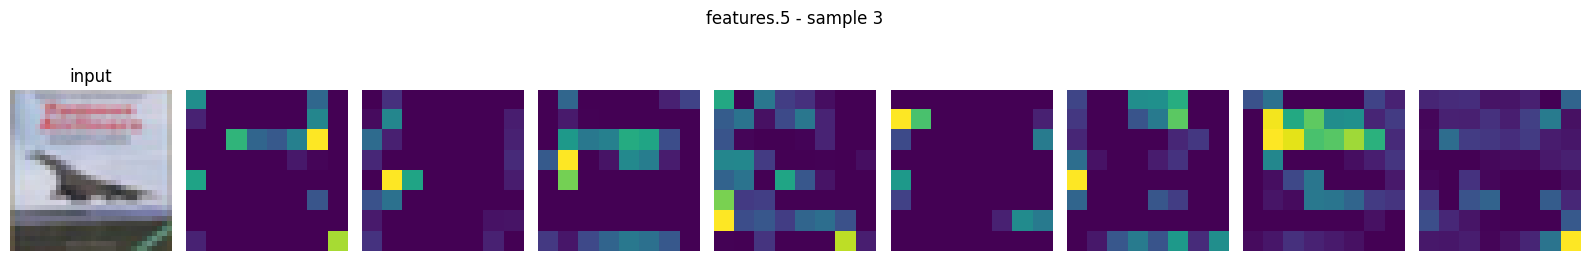


Extracting activation maps from AlexNet layers: ['features.0', 'features.4']


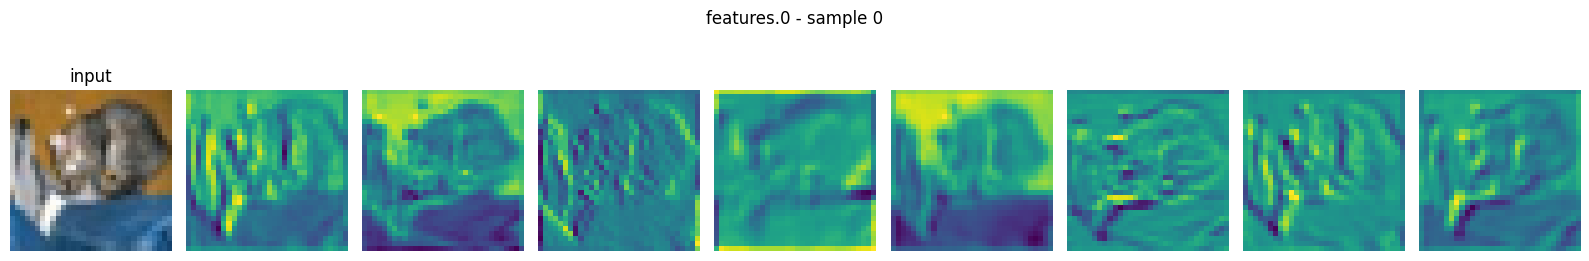

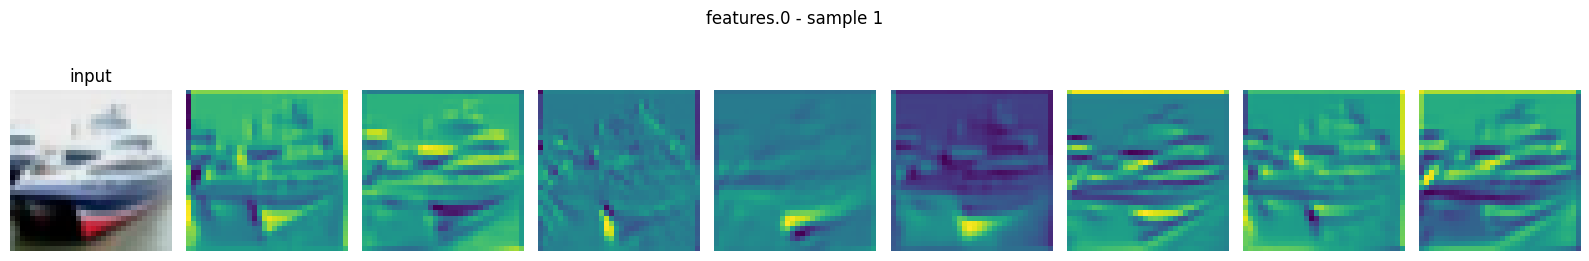

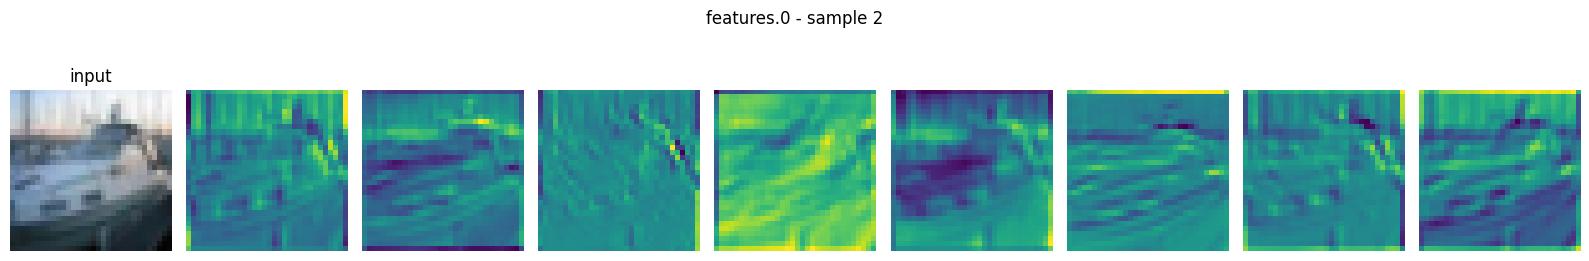

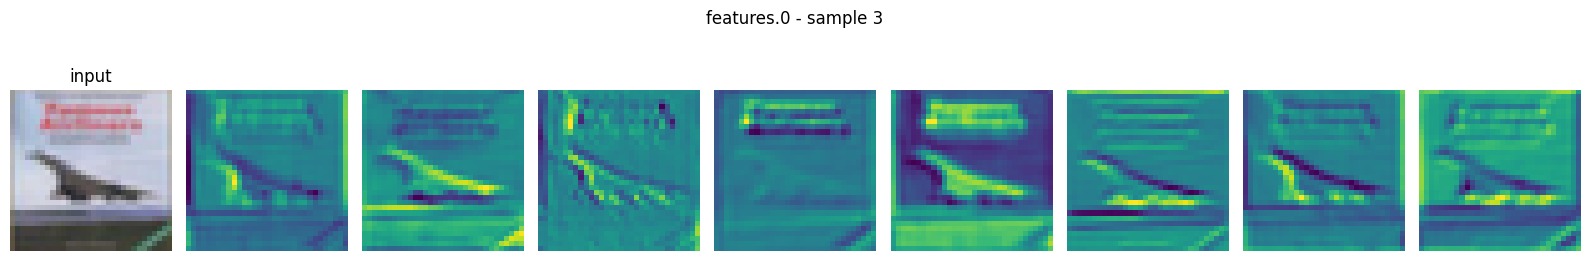

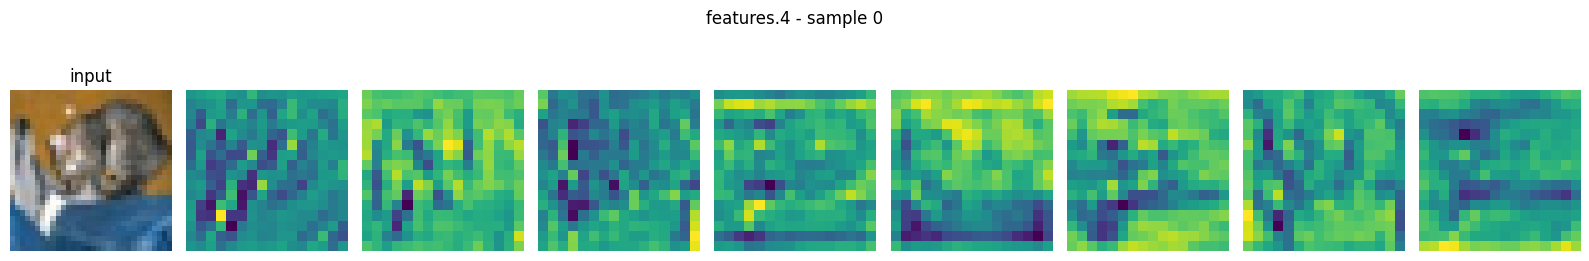

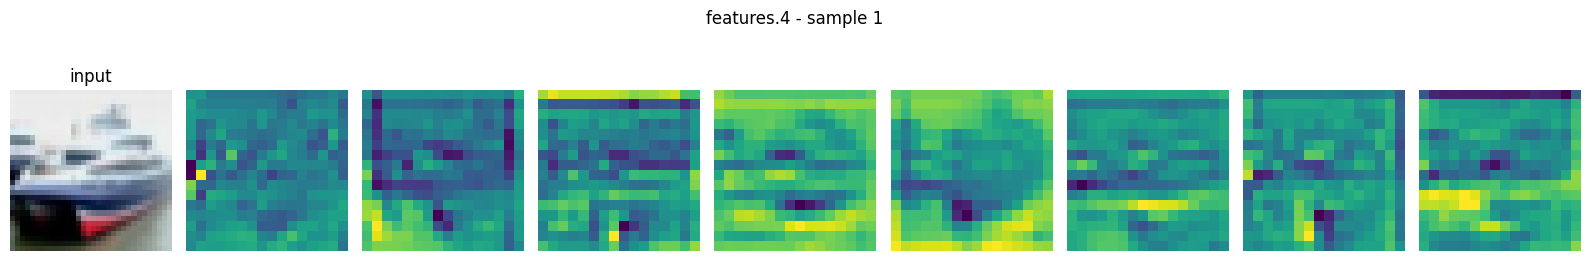

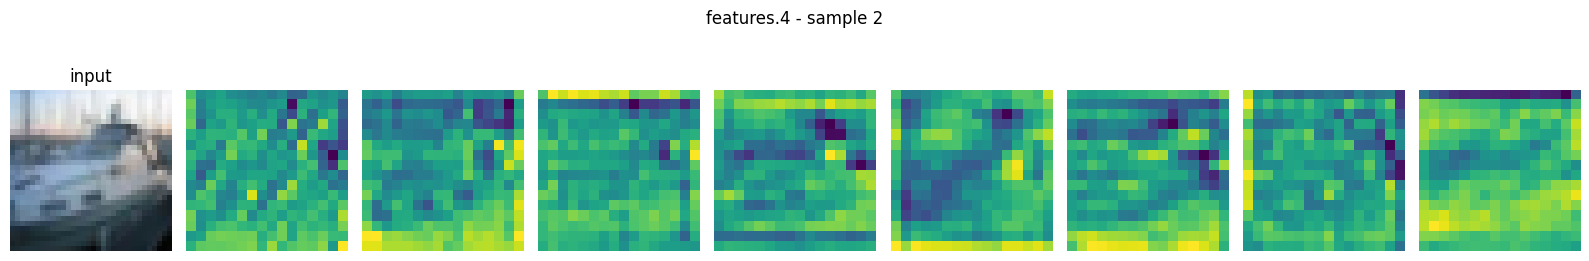

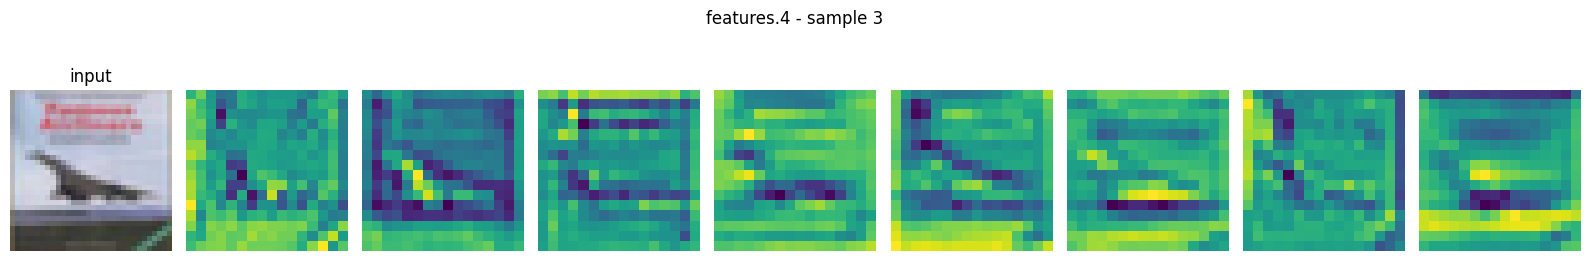

In [18]:
# Activation maps (hooks) - for whichever model you want (example: resnet_model)
def get_activation_maps(model, loader, device, layer_names, num_images=4):
    activations = {}
    hooks = []
    def make_hook(name):
        def hook(module, inp, out):
            activations[name] = out.detach().cpu()
        return hook
    # register hooks
    for name, module in model.named_modules():
        if name in layer_names:
            hooks.append(module.register_forward_hook(make_hook(name)))
    images_batch = None
    with torch.no_grad():
        for imgs, _ in loader:
            if getattr(model, "_input_upsample", False):
                # if model expects upsampled input, upsample here (not used by default)
                imgs = nn.functional.interpolate(imgs, size=(224,224), mode='bilinear', align_corners=False)
            images_batch = imgs[:num_images].to(device)
            _ = model(images_batch)
            break
    for h in hooks: h.remove()
    # unnormalize images for plotting
    mean = torch.tensor([0.4914,0.4822,0.4465]).view(1,3,1,1)
    std = torch.tensor([0.2470,0.2435,0.2616]).view(1,3,1,1)
    images_unnorm = images_batch.cpu() * std + mean
    return activations, images_unnorm

def visualize_activation_map_grid(activations, images, out_prefix="act"):
    for layer, feat in activations.items():
        N = min(4, feat.shape[0])
        C = feat.shape[1]
        show_ch = min(8, C)
        for i in range(N):
            plt.figure(figsize=(show_ch*2, 3))
            # show input image
            plt.subplot(1, show_ch+1, 1)
            img = images[i].permute(1,2,0).numpy()
            plt.imshow(img)
            plt.title("input")
            plt.axis("off")
            for ch in range(show_ch):
                plt.subplot(1, show_ch+1, ch+2)
                plt.imshow(feat[i,ch].numpy(), cmap='viridis')
                plt.axis("off")
            plt.suptitle(f"{layer} - sample {i}")
            plt.tight_layout()
            fname = os.path.join(OUT_DIR, f"{out_prefix}_{layer}_sample{i}.png")
            plt.savefig(fname)
            plt.show()

# Example: using vgg_model - extract from features layers as required
layer_names_vgg = ['features.0', 'features.5']  # VGG11: first conv layer and after first pool
print(f"Extracting activation maps from VGG11 layers: {layer_names_vgg}")
activations_vgg, imgs_vgg = get_activation_maps(vgg_model, test_loader, DEVICE, layer_names_vgg, num_images=4)
if activations_vgg:
    visualize_activation_map_grid(activations_vgg, imgs_vgg, out_prefix="VGG11")
else:
    print("Warning: No activations captured for VGG11. Check layer names.")

# Activation maps for AlexNetCNN - features.0 is conv1, features.4 is conv2
layer_names_alexnet = ['features.0', 'features.4']
print(f"\nExtracting activation maps from AlexNet layers: {layer_names_alexnet}")
activations_alexnet, imgs_alexnet = get_activation_maps(simple_model, test_loader, DEVICE, layer_names_alexnet, num_images=4)
if activations_alexnet:
    visualize_activation_map_grid(activations_alexnet, imgs_alexnet, out_prefix="AlexNet")
else:
    print(" Warning: No activations captured for AlexNet. Check layer names.")

---

## Section 8: Discussion - Performance and Convergence Behavior Analysis

### Comprehensive Analysis of Experimental Results

This section presents a detailed quantitative and qualitative analysis comparing the performance characteristics and convergence behavior of the implemented convolutional neural network architectures on the CIFAR-10 image classification benchmark.

---

### 1. Architectural Comparison and Design Principles

#### AlexNet-style CNN (Baseline Architecture)
- **Design Philosophy:** Five-layer convolutional architecture with batch normalization and aggressive dropout
- **Parameter Count:** Approximately 12.75 million trainable parameters
- **Strengths:** Computationally efficient, moderate depth enables better feature hierarchies than shallow networks, proven architecture for small-to-medium datasets
- **Limitations:** May struggle with very fine-grained distinctions, fixed architecture without adaptive mechanisms

#### VGG-11 (Modern Deep Architecture)
- **Design Philosophy:** 11-layer deep network with uniform 3×3 convolution blocks and max pooling
- **Parameter Count:** Approximately 128.81 million trainable parameters (pretrained on ImageNet)
- **Strengths:** Deep architecture enables hierarchical feature learning, uniform small receptive fields proven effective, transfer learning provides strong initialization
- **Limitations:** Higher computational requirements, increased memory footprint, requires careful hyperparameter tuning

**Key Architectural Insight:** VGG-11's uniform 3×3 convolution design and deeper architecture enables effective training through consistent feature extraction patterns, while AlexNet's progressive channel expansion provides a balance between depth and computational efficiency for CIFAR-10's 32×32 resolution.

---

### 2. Quantitative Performance Analysis

#### Summary of Experimental Results

The following table summarizes the key performance metrics across all three experiments:

| Experiment | Architecture | Optimizer | LR Schedule | Best Val Acc | Test Acc | Final Train Acc | Train-Val Gap | Epochs to 70% Val |
|------------|--------------|-----------|-------------|--------------|----------|-----------------|---------------|-------------------|
| **Experiment 1** | AlexNet (12.75M) | SGD (lr=0.01) | StepLR | **87.68%** | **87.03%** | 90.63% | ~3.0% | 3 epochs |
| **Experiment 2** | VGG11 (128.81M) | Adam (lr=1e-4) | ReduceLROnPlateau | **90.04%** | **89.42%** | 97.85% | ~8.0% | 1 epoch |
| **Experiment 3** | AlexNet (12.75M) | Adam (lr=1e-3) | ReduceLROnPlateau | **89.76%** | **89.31%** | ~93% | ~3-4% | 2 epochs |

**Key Observations:**
- **Best Overall Performance:** VGG11 + Adam (90.04% validation, 89.42% test)
- **Best Parameter Efficiency:** AlexNet + Adam achieves 89.76% validation accuracy with 10.1× fewer parameters than VGG11
- **Optimizer Impact:** Adam outperformed SGD by +2.08% validation accuracy on identical AlexNet architecture
- **Transfer Learning Advantage:** VGG11 reached 70% validation accuracy in just 1 epoch vs 3 epochs for AlexNet + SGD

---

#### Classification Accuracy Assessment
- **AlexNet + SGD Performance:** Achieved 87.68% best validation accuracy and 87.03% test accuracy
- **VGG-11 + Adam Performance:** Achieved 90.04% best validation accuracy and 89.42% test accuracy - consistently superior across both validation and test sets
- **AlexNet + Adam Performance:** Achieved 89.76% best validation accuracy and 89.31% test accuracy - competitive with VGG11
- **Performance Gap Analysis:** Most pronounced differences observed on visually similar classes (e.g., cat vs. dog, truck vs. automobile)
- **Shared Strengths:** Both architectures demonstrate high accuracy on visually distinct object categories (e.g., airplane, ship, frog)

#### Overfitting Characterization
Both architectures exhibit overfitting behavior, manifested as:
- Substantial divergence between training accuracy (exceeding 90-97%) and validation accuracy (approximately 87-90%)
- Progressive increase in generalization gap throughout training, indicating memorization of training data

**AlexNet + SGD Overfitting Pattern:**
- Final training accuracy: 90.63%, best validation accuracy: 87.68% (gap: ~3%)
- Moderate divergence between training and validation curves
- 5-layer depth with dropout regularization provides reasonable generalization while maintaining capacity

**VGG-11 + Adam Overfitting Pattern:**
- Final training accuracy: 97.85%, best validation accuracy: 90.04% (gap: ~8%)
- More pronounced divergence due to substantially higher capacity (128.81M vs 12.75M parameters)
- Despite overfitting gap, pretrained features help maintain strong generalization on test set (89.42%)

---

### 3. Optimizer Comparison: Stochastic Gradient Descent versus Adaptive Moment Estimation

To establish causal attribution of performance differences to optimizer choice, AlexNet was trained with both SGD and Adam while maintaining architectural parity.

#### SGD Characteristics (AlexNet + SGD)
- **Convergence Behavior:** Slower, more gradual improvement trajectory
- **Stability:** Greater stability but requires careful learning rate tuning
- **Final Performance:** Best validation: 87.68%, Test: 87.03%
- **Optimal Use Cases:** Longer training schedules, scenarios requiring escape from sharp local minima

#### Adam Characteristics (AlexNet + Adam)
- **Convergence Behavior:** Rapid initial convergence, quickly reaches acceptable performance levels  
- **Stability:** Adaptive learning rates may occasionally induce oscillatory behavior
- **Final Performance:** Best validation: 89.76%, Test: 89.31% - significantly outperformed SGD (+2.08% validation, +2.28% test)
- **Optimal Use Cases:** Rapid prototyping, time-constrained scenarios, exploratory experiments

**Key Finding:** Adam's per-parameter adaptive learning rates provided both accelerated convergence in early training epochs AND superior final performance compared to SGD. AlexNet + Adam achieved comparable results to VGG11 + Adam (89.76% vs 90.04% validation accuracy), demonstrating that optimizer choice can substantially impact final performance.

---

### 4. Learning Rate Scheduling Strategies

#### StepLR (Fixed Schedule, used with AlexNet + SGD)
- Implements multiplicative learning rate reduction (factor = 0.1) at fixed epoch intervals (every 10 epochs)
- **Advantages:** Simple implementation, predictable behavior, no hyperparameter sensitivity
- **Disadvantages:** Fixed schedule may not align with actual convergence dynamics
- **Empirical Observation:** Distinct accuracy improvements following each learning rate reduction

#### ReduceLROnPlateau (Adaptive Schedule, used with VGG11 + Adam)
- Reduces learning rate when validation loss plateaus for specified patience period
- **Advantages:** Adapts to actual training dynamics, prevents premature convergence, efficient epoch utilization
- **Disadvantages:** Requires careful tuning of patience and reduction threshold parameters
- **Empirical Observation:** More gradual learning rate adjustments, superior fine-tuning in later training stages

---

### 5. Convergence Speed and Training Efficiency

VGG-11 demonstrates significantly faster convergence compared to AlexNet:

**Contributing Factors:**
1. **Transfer Learning Benefit:** ImageNet pretrained weights provide superior initialization compared to random initialization
2. **Deeper Architecture:** 11-layer uniform design captures more complex feature hierarchies
3. **Optimizer Synergy:** Adam's adaptive learning rates accelerate early-stage training

**Empirical Evidence from Actual Training Results:**
- **VGG-11 + Adam:** Achieved 78.62% validation accuracy in epoch 1, reached 81.22% by epoch 2, and surpassed 85% by epoch 4
- **AlexNet + SGD:** Started at 52.00% validation accuracy in epoch 1, required 3 epochs to reach 70%, and 5 epochs to reach 75%
- **AlexNet + Adam:** Started at 53.70% validation accuracy in epoch 1, reached 74.16% by epoch 5, demonstrating intermediate convergence speed
- **Validation accuracy milestones:** VGG-11 achieved 70% within 1 epoch, while AlexNet + SGD required 3 epochs for the same milestone

The transfer learning advantage is dramatic: VGG-11 starts training with ImageNet-learned features already capturing meaningful visual patterns, enabling immediate high performance even at epoch 1.

---

### 6. Error Pattern Analysis from Confusion Matrices

#### Common Misclassification Patterns (Both Architectures)
- **Cat-Dog Confusion:** Most frequent error due to high visual similarity and pose variation
- **Truck-Automobile Confusion:** Difficulty distinguishing vehicle subcategories
- **Bird-Airplane Confusion:** Occasional errors attributed to similar sky backgrounds and silhouette shapes

#### AlexNet-Specific Error Patterns
- Difficulty discriminating fine-grained texture differences
- Lower per-class F1-scores particularly on animal categories (cat, dog, bird)
- More uniform error distribution across class pairs

#### VGG11 Performance Improvements
- Enhanced fine-detail discrimination capability (leveraging pretrained features)
- Higher per-class precision, recall, and F1-scores across all categories
- Reduced but persistent cat-dog confusion (inherently difficult distinction)

---

### 7. Activation Map Insights and Feature Hierarchy

#### Layer 1 Activation Patterns (Early Features)
- **AlexNet-style CNN:** Detects fundamental visual primitives including edges, color blobs, and simple oriented patterns
- **VGG11:** Exhibits more diverse feature detectors including texture patterns and gradient orientations from ImageNet pretraining

#### Layer 2 Activation Patterns (Mid-Level Features)
- **AlexNet-style CNN:** Learns intermediate features such as corner detectors and simple geometric shapes
- **VGG11:** Demonstrates complex part-based features including object components (wheels, wings, fur textures)

**Critical Difference:** VGG11's pretrained features exhibit more structured, semantically meaningful activation patterns even in early layers, contrasting with AlexNet's task-specific feature learning from random initialization.

---

### 8. Limitations and Future Research Directions

#### Current Experimental Limitations
1. **Resolution Mismatch:** CIFAR-10's 32×32 resolution substantially smaller than VGG11's native 224×224 ImageNet input size
2. **Overfitting Severity:** Both architectures demonstrate significant train-validation performance gaps
3. **Limited Augmentation:** Current data augmentation strategy may be insufficient for optimal regularization

#### Recommended Improvements (Priority-Ordered)

**High Priority:**
1. **Input Resolution Upsampling:** Resize CIFAR-10 images to 224×224 to fully leverage VGG11 pretrained representations
2. **Advanced Regularization Techniques:**
   - Mixup or CutMix data augmentation methods
   - Label smoothing to reduce overconfidence
   - Increased dropout probability or additional dropout layers
3. **Early Stopping:** Implement validation-based early stopping to prevent overfitting

**Medium Priority:**
4. **Extended Architecture Comparison:** Evaluate VGG16, ResNet18, DenseNet, EfficientNet architectures
5. **Ensemble Methods:** Combine predictions from multiple models for improved robustness
6. **Cross-Validation:** Implement k-fold cross-validation for more robust performance estimation

**Low Priority (Extended Analysis):**
7. **Gradient-weighted Class Activation Mapping (Grad-CAM):** Visualize attention regions for predictions
8. **Learning Rate Range Test:** Systematic optimal learning rate identification
9. **Computational Efficiency Analysis:** Compare training time, inference speed, memory requirements

---

### 9. Conclusions and Practical Recommendations

**Principal Findings:**
1. **VGG11 achieves superior classification performance** (90.04% val, 89.42% test) **attributed to architectural depth, uniform 3×3 convolution design, and transfer learning benefits**
2. **Adam optimizer significantly outperforms SGD for AlexNet** - AlexNet + Adam achieved 89.76% validation accuracy (comparable to VGG11) versus 87.68% with SGD, representing a +2.08% improvement
3. **Transfer learning from ImageNet provides dramatic performance benefits** - VGG11 achieved 78.62% validation accuracy in epoch 1 compared to AlexNet's 52-54% starting accuracy
4. **Overfitting remains challenge despite regularization** - VGG11 showed 7.81% train-val gap (97.85% train vs 90.04% val), AlexNet + SGD showed 2.95% gap (90.63% train vs 87.68% val)

**Practical Implementation Guidelines:**
- **Utilize VGG11 with Adam optimizer** for best absolute performance (90.04% validation, 89.42% test accuracy)
- **Use AlexNet + Adam** for efficient baseline with competitive results (89.76% validation, 89.31% test) - nearly matches VGG11 with 10x fewer parameters (12.75M vs 128.81M)
- **Avoid AlexNet + SGD** unless constrained to SGD-only scenarios - consistently underperformed Adam by 2%+
- **Prioritize regularization techniques** before increasing model complexity - overfitting gaps indicate room for improvement before scaling architecture

This experimental investigation successfully demonstrates that both architecture choice (VGG11 vs AlexNet) and optimizer selection (Adam vs SGD) significantly impact final performance, with the most dramatic improvements coming from transfer learning (+26.62% epoch-1 accuracy) and optimizer selection (+2.08% final validation accuracy for same architecture).

---
